In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import scipy.stats as stats

In [2]:
# Find the paths to all the nhts provided data
datafolder = "nhts-data/"
perpub_file = datafolder + "perpub.csv"
trippub_file = datafolder + "trippub.csv"

In [3]:
# Load all of the raw data
perpub_df = pd.read_csv(perpub_file)
trippub_df = pd.read_csv(trippub_file)

In [4]:
with pd.option_context('display.max_columns', None):
    display(perpub_df)

,HOUSEID,PERSONID,R_AGE,EDUC,R_HISP,R_RELAT,R_SEX,R_RACE,PRMACT,PAYPROF,GT1JBLWK,WRK_HOME,WKFTPT,WRKTRANS,LSTTRDAY17,OCCAT,SCHTYP,NWALKTRP,WALK4EX,NBIKETRP,BIKE4EX,BIKESHARE,PTUSED,MCUSED,CARSHARE,RIDESHARE,CARRODE,TIMETOWK,NOCONG,PUBTIME,WRKTIME,WKRMHM,FLEXTIME,WKFMHMXX,SCHTRN1,SCHTRN2,DELIVER,MEDCOND,MEDCOND6,HEALTH,PHYACT,VPACT,LPACT,BORNINUS,YRTOUS,YEARMILE,PROXY,WHOPROXY,USEPUBTR,SAMEPLC,W_NONE,W_CANE,W_WLKR,W_WHCANE,W_DOG,W_CRUTCH,W_SCOOTR,W_CHAIR,W_MTRCHR,WORKER,DIARY,OUTCNTRY,FRSTHM17,CNTTDTR,GCDWORK,WKSTFIPS,DRIVER,OUTOFTWN,DISTTOWK17,DISTTOSC17,R_AGE_IMP,R_SEX_IMP,ALT_16,ALT_23,ALT_45,WALK_DEF,WALK_GKQ,BIKE_DFR,BIKE_GKP,CONDTRAV,CONDRIDE,CONDNIGH,CONDRIVE,CONDPUB,CONDSPEC,CONDTAX,TRAVDAY,HOMEOWN,HHSIZE,HHVEHCNT,HHFAMINC,DRVRCNT,HHSTATE,HHSTFIPS,NUMADLT,WRKCOUNT,TDAYDATE,HHRESP,LIF_CYC,MSACAT,MSASIZE,RAIL,URBAN,URBANSIZE,URBRUR,CENSUS_D,CENSUS_R,CDIVMSAR,HH_RACE,HH_HISP,HH_CBSA,SMPLSRCE,WTPERFIN,HBHUR,HTHTNRNT,HTPPOPDN,HTRESDN,HTEEMPDN,HBHTNRNT,HBPPOPDN,HBRESDN
0,30000007,1,67,3,2,1,2,2,6,2,-1,-1,-1,-1,-1,-1,-1,3,3,0,-1,-1,0,-1,0,0,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,2,2,-1,2,2,-1,0,1,-1,1000,1,1,2,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,2,2,2,1,2,-9.00,-9,1,2,-9.00,-9.00,67,2,3,1,4,3,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,2,1,3,5,7,3,NC,37,3,1,201608,1,10,3,1,2,1,1,1,5,3,53,2,2,XXXXX,2,206.690153,T,50,1500,750,750,20,750,300
1,30000007,2,66,3,2,2,1,2,1,-1,2,2,1,6,-1,2,-1,7,0,0,-1,-1,0,-1,0,0,1,120,90,-1,08:30 PM,2,2,-1,-1,-1,5,2,-1,2,2,-1,7,1,-1,10000,2,1,2,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,1,2,2,2,2,58.58,37,1,2,82.61,-9.00,66,1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,2,1,3,5,7,3,NC,37,3,1,201608,1,10,3,1,2,1,1,1,5,3,53,2,2,XXXXX,2,197.075742,T,50,1500,750,750,20,750,300
2,30000007,3,28,2,2,3,2,2,5,2,-1,-1,-1,-1,-1,-1,-1,7,0,0,-1,-1,0,-1,0,0,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,0,2,-1,2,2,-1,2,1,-1,1000,2,1,2,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,2,2,2,1,2,-9.00,-9,1,2,-9.00,-9.00,28,2,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,2,1,3,5,7,3,NC,37,3,1,201608,1,10,3,1,2,1,1,1,5,3,53,2,2,XXXXX,2,219.514210,T,50,1500,750,750,20,750,300
3,30000008,1,55,5,2,1,1,1,1,-1,2,2,1,6,-1,4,-1,5,0,0,-1,-1,0,-1,0,0,1,10,10,-1,06:15 AM,2,2,-1,-1,-1,0,2,-1,2,3,7,-1,1,-1,12000,1,1,2,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,1,2,2,1,2,5.53,55,1,2,8.11,-9.00,55,1,4,4,4,1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,5,1,2,4,8,2,WI,55,2,2,201608,2,2,2,5,2,4,6,2,3,2,32,1,2,33460,2,63.185911,R,5,300,300,150,5,300,300
4,30000008,2,49,4,2,2,2,1,1,-1,2,2,1,3,1,2,-1,0,-1,0,-1,-1,0,-1,0,0,1,5,4,-1,09:00 AM,2,2,-1,-1,-1,0,2,-1,2,2,-1,7,1,-1,10000,1,2,2,10,-1,-1,-1,-1,-1,-1,-1,-1,-1,1,1,2,1,0,2.22,55,1,2,3.07,-9.00,49,2,4,1,4,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,5,1,2,4,8,2,WI,55,2,2,201608,2,2,2,5,2,4,6,2,3,2,32,1,2,33460,2,58.665911,R,5,300,300,150,5,300,300
5,30000012,1,45,5,2,1,2,1,1,-1,2,2,1,3,-1,4,-1,6,6,0,-1,-1,0,-1,0,0,1,30,12,-1,07:30 AM,2,2,-1,-1,-1,5,2,-1,2,3,7,-1,1,-1,17000,1,1,2,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,1,1,2,1,9,4.60,36,1,2,6.82,-9.00,45,2,3,1,3,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,5,1,1,2,10,1,NY,36,1,1,201607,1,1,3,3,2,1,3,1,2,1,23,1,2,XXXXX,2,58.966275,C,80,17000,17000,5000,60,17000,7000
6,30000019,1,68,1,2,1,1,1,97,2,-1,-1,-1,-1,-1,-1,-1,7,7,0,-1,-1,0,-1,0,0,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,2,2,-1,3,2,-1,3,1,-1,15000,1,1,2,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,2,2,2,1,2,-9.00,-9,1,2,-9.00,-9.00,68,1,3,1,4,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,5,1,2,2,3,2,MD,24,2,0,201605,1,2,3,2,2,1,1,1,5,3,53,1,2,XXXXX,2,233.138565,S,40,300,300,150,50,750,300
7,30000019,2,66,2,2,2,2,1,4,2,-1,-1,-1,-1,-1,-1,-1,7,7,0,-1,-1,0,-1,0,0,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,1,2,-1,3,2,-1,3,1,-1,5000,2,1,2,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,2,2,2,1,2,-9.00,-9,1,2,-9.00,-9.00,66,2,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,5,1,2,2,3,2,MD,24,2,0,201605,1,2,3,2,2,1,1,1,5,3,53,1,2,XXXXX,2,249.148185,S,40,300,300,150,50,750,300
8,30000029,1,72,3,2,1,1,1,6,2,-1,-1,-1,-1,-1,-1,-1,0,-1,0,-1,-1,0,-1,0,0,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,1,2,-1,2,2,-1,1,1,-1,15000,1,1,2,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,2,1,2,1,3,-9.00,-9,1,2,-9.00,-9.00,72,1,4,1,4,-1,-1,-1,-1,-1,-1,-1,-1,-

In [5]:
# Filter perpub to only include the data possibly relevant to our parameters
# HOUSEID = household label
# PERSONID = person number for household
# GT1JBLWK = More than 1 job. 1 = yes, 2 = No, others not acquired or not relevant
# WRK_HOME = Work from home. 1 = yes, 2 = No, others not acquired or not relevant
# WRKTRANS = Transportation mode to work: 1 = Walk, 3 = Car, 4 = SUV, 5 = Van, 6 = Pickup Truck. Others can't be represented
# NWALKTRP = Count of walk trips on travel data
# TIMETOWK = time to work in minutes
# NOCONG = time to work in minutes with no traffic
# WRKTIME = work arrival time
# SCHTRN1 = Mode to school
# SCHTRN2 = Mode from school
# FRSTHM17 = Travel began at home location
# CNTTDTR = Count of person trips on travel day
# GCDWORK = Minimum geodesic distance between home
# TRAVDAY = Travel day of the week. 1 = Sunday, 7 = Saturday
# SCHTYP = Student status. 1 = Public/private school, 2 = Home schooled, 3 = Not in school
# HHSIZE = Household size
# R_AGE_IMP = Person age
# WORKER = Are tehy a worker? 1 = Yes, 2 = No

kept_columns = ["HOUSEID", "PERSONID", "R_AGE_IMP", "WORKER", "TRAVDAY"]
perpub_df_reduced = perpub_df[kept_columns]
perpub_df_reduced


,HOUSEID,PERSONID,R_AGE_IMP,WORKER,TRAVDAY
0,30000007,1,67,2,2
1,30000007,2,66,1,2
2,30000007,3,28,2,2
3,30000008,1,55,1,5
4,30000008,2,49,1,5
5,30000012,1,45,1,5
6,30000019,1,68,2,5
7,30000019,2,66,2,5
8,30000029,1,72,2,3
9,30000029,2,72,2,3


In [6]:
with pd.option_context('display.max_columns', None):
    display(trippub_df)

,HOUSEID,PERSONID,TDTRPNUM,STRTTIME,ENDTIME,TRVLCMIN,TRPMILES,TRPTRANS,TRPACCMP,TRPHHACC,VEHID,TRWAITTM,NUMTRANS,TRACCTM,DROP_PRK,TREGRTM,WHODROVE,WHYFROM,LOOP_TRIP,TRPHHVEH,HHMEMDRV,HH_ONTD,NONHHCNT,NUMONTRP,PSGR_FLG,PUBTRANS,TRIPPURP,DWELTIME,TDWKND,VMT_MILE,DRVR_FLG,WHYTRP1S,ONTD_P1,ONTD_P2,ONTD_P3,ONTD_P4,ONTD_P5,ONTD_P6,ONTD_P7,ONTD_P8,ONTD_P9,ONTD_P10,ONTD_P11,ONTD_P12,ONTD_P13,TDCASEID,TRACC_WLK,TRACC_POV,TRACC_BUS,TRACC_CRL,TRACC_SUB,TRACC_OTH,TREGR_WLK,TREGR_POV,TREGR_BUS,TREGR_CRL,TREGR_SUB,TREGR_OTH,WHYTO,TRAVDAY,HOMEOWN,HHSIZE,HHVEHCNT,HHFAMINC,DRVRCNT,HHSTATE,HHSTFIPS,NUMADLT,WRKCOUNT,TDAYDATE,HHRESP,LIF_CYC,MSACAT,MSASIZE,RAIL,URBAN,URBANSIZE,URBRUR,GASPRICE,CENSUS_D,CENSUS_R,CDIVMSAR,HH_RACE,HH_HISP,HH_CBSA,SMPLSRCE,R_AGE,EDUC,R_SEX,PRMACT,PROXY,WORKER,DRIVER,WTTRDFIN,WHYTRP90,R_AGE_IMP,R_SEX_IMP,HBHUR,HTHTNRNT,HTPPOPDN,HTRESDN,HTEEMPDN,HBHTNRNT,HBPPOPDN,HBRESDN
0,30000007,1,1,1000,1015,15,5.244,3,0,0,3,-1,-1,-1,-1,-1,1,1,2,1,1,1,0,1,2,2,HBO,295,2,5.244,1,20,1,2,2,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,300000070101,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,19,2,1,3,5,7,3,NC,37,3,1,201608,1,10,3,1,2,1,1,1,228.4,5,3,53,2,2,XXXXX,2,67,3,2,6,1,2,1,75441.905796,5,67,2,T,50,1500,750,750,20,750,300
1,30000007,1,2,1510,1530,20,5.149,3,0,0,3,-1,-1,-1,-1,-1,1,19,2,1,1,1,0,1,2,2,HBO,-9,2,5.149,1,1,1,2,2,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,300000070102,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,1,2,1,3,5,7,3,NC,37,3,1,201608,1,10,3,1,2,1,1,1,228.4,5,3,53,2,2,XXXXX,2,67,3,2,6,1,2,1,75441.905796,5,67,2,T,50,1500,750,750,20,750,300
2,30000007,2,1,700,900,120,84.004,6,0,0,5,-1,-1,-1,-1,-1,2,3,2,1,1,1,0,1,2,2,HBW,540,2,84.004,1,1,2,1,2,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,300000070201,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,1,2,1,3,5,7,3,NC,37,3,1,201608,1,10,3,1,2,1,1,1,228.4,5,3,53,2,2,XXXXX,2,66,3,1,1,2,1,1,71932.645806,1,66,1,T,50,1500,750,750,20,750,300
3,30000007,2,2,1800,2030,150,81.628,6,0,0,5,-1,-1,-1,-1,-1,2,1,2,1,1,1,0,1,2,2,HBW,-9,2,81.628,1,10,2,1,2,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,300000070202,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,3,2,1,3,5,7,3,NC,37,3,1,201608,1,10,3,1,2,1,1,1,228.4,5,3,53,2,2,XXXXX,2,66,3,1,1,2,1,1,71932.645806,1,66,1,T,50,1500,750,750,20,750,300
4,30000007,3,1,845,900,15,2.250,3,0,0,1,-1,-1,-1,-1,-1,3,1,2,1,1,1,0,1,2,2,HBO,330,2,2.250,1,20,2,2,1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,300000070301,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,8,2,1,3,5,7,3,NC,37,3,1,201608,1,10,3,1,2,1,1,1,228.4,5,3,53,2,2,XXXXX,2,28,2,2,5,2,2,1,80122.686739,5,28,2,T,50,1500,750,750,20,750,300
5,30000007,3,2,1430,1445,15,2.243,3,0,0,1,-1,-1,-1,-1,-1,3,8,2,1,1,1,0,1,2,2,HBO,-9,2,2.243,1,1,2,2,1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,300000070302,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,1,2,1,3,5,7,3,NC,37,3,1,201608,1,10,3,1,2,1,1,1,228.4,5,3,53,2,2,XXXXX,2,28,2,2,5,2,2,1,80122.686739,5,28,2,T,50,1500,750,750,20,750,300
6,30000008,1,1,1115,1130,15,8.017,6,0,0,4,-1,-1,-1,-1,-1,1,1,2,1,1,1,0,1,2,2,HBW,720,2,8.017,1,10,1,2,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,300000080101,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,3,5,1,2,4,8,2,WI,55,2,2,201608,2,2,2,5,2,4,6,2,225.9,3,2,32,1,2,33460,2,55,5,1,1,1,1,1,23062.857428,1,55,1,R,5,300,300,150,5,300,300
7,30000008,1,2,2330,2340,10,8.017,6,0,0,4,-1,-1,-1,-1,-1,1,3,2,1,1,1,0,1,2,2,HBW,-9,2,8.017,1,1,1,2,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,300000080102,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,1,5,1,2,4,8,2,WI,55,2,2,201608,2,2,2,5,2,4,6,2,225.9,3,2,32,1,2,33460,2,55,5,1,1,1,1,1,23062.857428,1,55,1,R,5,300,300,150,5,300,300
8,30000012,1,1,550,605,15,3.395,4,0,0,2,-1,-1,-1,-1,-1,1,1,2,1,1,1,0,1,2,2,HBSOCREC,55,2,3.395,1,50,1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,300000120101,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,16,5,1,1,2,10,1,NY,36,1,1,201607,1,1,3,3,2,1,3,1,233.8,2,1,23,1,2,XXXXX,2,45,5,2,1,1,1,1,21522.690513,10,45,2,C,80,17000,17000,5000,60,17000,7000
9,30000012,1,2,700,715,15,3.395,4,0,0,2,-1,-1,-1,-1,-1,1,16,2,1,1,1,0,1,2,2,HBSOCREC,15,2,3.395,1,1,1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,300000120102,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,1,5,1,1,2,10,1,NY,36,1,1,201607,1,1,3,3,

In [7]:
# Filter trippub to only include the data possibly relevant to our parameters
# HOUSEID = household label
# PERSONID = person number for household
# TDTRPNUM = Counter for each trip a person takes
# STRTTIME = start time for a trip
# ENDTIME = end time for a trip
# TRVLCMIN = trip duration in minutes
# TRPMILES = trip distance in miles
# TRPTRANS = trip mode. We care about 1 = walk, 3 = car, 4 = SUV, 5 = Van, 6 = pickup truck. We will group 3-6 together
# WHYFROM = trip origin purpose. See https://nhts.ornl.gov/assets/codebook_v1.1.pdf for encoding.
# WHYTO trip destination purpose
# LOOP_TRIP = Are the start and end locations the same? 1 = Yes, 2 = No
# DWELTIME = Time at destination in minutes
kept_columns = ["HOUSEID", "PERSONID", "TDTRPNUM", "TRPMILES", "TRPTRANS", "WHYFROM", "LOOP_TRIP", "DWELTIME", "WHYTO", "STRTTIME"]
trippub_df_reduced = trippub_df[kept_columns]
trippub_df_reduced

,HOUSEID,PERSONID,TDTRPNUM,TRPMILES,TRPTRANS,WHYFROM,LOOP_TRIP,DWELTIME,WHYTO,STRTTIME
0,30000007,1,1,5.244,3,1,2,295,19,1000
1,30000007,1,2,5.149,3,19,2,-9,1,1510
2,30000007,2,1,84.004,6,3,2,540,1,700
3,30000007,2,2,81.628,6,1,2,-9,3,1800
4,30000007,3,1,2.250,3,1,2,330,8,845
5,30000007,3,2,2.243,3,8,2,-9,1,1430
6,30000008,1,1,8.017,6,1,2,720,3,1115
7,30000008,1,2,8.017,6,3,2,-9,1,2330
8,30000012,1,1,3.395,4,1,2,55,16,550
9,30000012,1,2,3.395,4,16,2,15,1,700


In [8]:
df_total = pd.merge(perpub_df_reduced, trippub_df_reduced, on=["HOUSEID","PERSONID"])
df_total["USERID"] = df_total["HOUSEID"].astype(str) + df_total["PERSONID"].astype(str)

with pd.option_context('display.max_columns', None):
    display(df_total)

,HOUSEID,PERSONID,R_AGE_IMP,WORKER,TRAVDAY,TDTRPNUM,TRPMILES,TRPTRANS,WHYFROM,LOOP_TRIP,DWELTIME,WHYTO,STRTTIME,USERID
0,30000007,1,67,2,2,1,5.244,3,1,2,295,19,1000,300000071
1,30000007,1,67,2,2,2,5.149,3,19,2,-9,1,1510,300000071
2,30000007,2,66,1,2,1,84.004,6,3,2,540,1,700,300000072
3,30000007,2,66,1,2,2,81.628,6,1,2,-9,3,1800,300000072
4,30000007,3,28,2,2,1,2.250,3,1,2,330,8,845,300000073
5,30000007,3,28,2,2,2,2.243,3,8,2,-9,1,1430,300000073
6,30000008,1,55,1,5,1,8.017,6,1,2,720,3,1115,300000081
7,30000008,1,55,1,5,2,8.017,6,3,2,-9,1,2330,300000081
8,30000012,1,45,1,5,1,3.395,4,1,2,55,16,550,300000121
9,30000012,1,45,1,5,2,3.395,4,16,2,15,1,700,300000121


In [9]:
# Filter our any respondants under the age of 18
df_filter = df_total[df_total.R_AGE_IMP >= 18]
df_filter = df_filter[df_filter.WORKER != -9]
df_filter = df_filter[df_filter.WORKER != -1]

In [10]:
# First select only the first trip
from_values = [1, 11, 3, 13]
walk_trips = [1]
bike_trips = [2]
car_trips = [3, 4, 5, 6, 17, 18]
transit_trips = [11, 12, 13, 14, 15, 16]
trip_numbers = walk_trips + bike_trips + car_trips + transit_trips
df_filter = df_filter[df_filter.WHYFROM.isin(from_values)]
df_filter = df_filter[df_filter.WHYTO.isin(from_values)]
df_filter = df_filter[df_filter.TRPTRANS.isin(trip_numbers)]
df_filter = df_filter[df_filter.TRAVDAY >= 2]
df_filter = df_filter[df_filter.TRAVDAY <= 6]




# Get the total number of workers
workers = last_trip_workers = df_filter.drop_duplicates(['USERID'])
workers = workers.groupby(["WORKER"])
workers.size()

WORKER
1    78107
2    41059
dtype: int64

In [11]:
# Generate information about each type of trip by grouping first by user type
worker_data = df_filter[df_filter.WORKER == 1]
home = 1
worker_data = worker_data[(worker_data.WHYFROM != home) | (worker_data.WHYTO != home)]
work = 3
worker_data = worker_data[(worker_data.WHYFROM != work) | (worker_data.WHYTO != work)]

In [12]:
# Remove the impact of round trips
# Reset the indices
worker_data.reset_index(inplace=True, drop=True)
spare_rows = []
for i in range(len(worker_data.index)):
    if (worker_data.at[i, "LOOP_TRIP"] == 1):
        worker_data.at[i, "TRPMILES"] = worker_data.at[i, "TRPMILES"] / 2.0
        spare_row = worker_data.iloc[i,:].copy(deep=True)
        spare_row["WHYTO"], spare_row["WHYFROM"]  = spare_row["WHYFROM"], spare_row["WHYTO"]
        spare_rows.append(spare_row)
for row in spare_rows:
    worker_data = worker_data.append(row)

In [13]:
# Generate the Markov Model
data = worker_data.groupby(["WHYFROM", "WHYTO"]).size()
vals = data.iteritems()
sums = {}
totals = {}
for val in vals:
    directions = val[0]
    count = val[1]
    from_i, to_i = directions
    if from_i not in totals:
        totals[from_i] = dict()
    if from_i not in sums:
        sums[from_i] = 0
    totals[from_i][to_i] = count
    sums[from_i] += count
for key, val in totals.items():
    for second_key, contents in val.items():
        totals[key][second_key] = contents / sums[key]
totals

{1: {3: 0.7385820700290525, 11: 0.14763104630509316, 13: 0.1137868836658543},
 3: {1: 0.7283850579369581, 11: 0.14034519082732355, 13: 0.13126975123571832},
 11: {1: 0.5950903281307607,
  3: 0.11727295071893819,
  11: 0.20950596042767605,
  13: 0.07813076072262505},
 13: {1: 0.46636351477865456,
  3: 0.38308590789532343,
  11: 0.11675805804467032,
  13: 0.0337925192813517}}

In [14]:
"""
bike_worker_data = worker_data[worker_data.TRPTRANS == 2]
data = bike_worker_data.groupby(["WHYFROM", "WHYTO"]).size()
vals = data.iteritems()
sums = {}
totals = {}
for val in vals:
    directions = val[0]
    count = val[1]
    from_i, to_i = directions
    if from_i not in totals:
        totals[from_i] = dict()
    if from_i not in sums:
        sums[from_i] = 0
    totals[from_i][to_i] = count
    sums[from_i] += count
for key, val in totals.items():
    for second_key, contents in val.items():
        totals[key][second_key] = contents / sums[key]
bike_worker_data
"""

'\nbike_worker_data = worker_data[worker_data.TRPTRANS == 2]\ndata = bike_worker_data.groupby(["WHYFROM", "WHYTO"]).size()\nvals = data.iteritems()\nsums = {}\ntotals = {}\nfor val in vals:\n    directions = val[0]\n    count = val[1]\n    from_i, to_i = directions\n    if from_i not in totals:\n        totals[from_i] = dict()\n    if from_i not in sums:\n        sums[from_i] = 0\n    totals[from_i][to_i] = count\n    sums[from_i] += count\nfor key, val in totals.items():\n    for second_key, contents in val.items():\n        totals[key][second_key] = contents / sums[key]\nbike_worker_data\n'

In [15]:
"""
# Reset the indices
worker_data.reset_index(inplace=True, drop=True)
# Generate a distribution of number of trips taken for workers
userid_counts = worker_data.groupby(["USERID"]).size()
counts = userid_counts.iteritems()
trip_lengths = {}
for elem in counts:
    value = elem[1]
    if value not in trip_lengths:
        trip_lengths[value] = 1
    else:
        trip_lengths[value] += 1
trip_lengths
"""

'\n# Reset the indices\nworker_data.reset_index(inplace=True, drop=True)\n# Generate a distribution of number of trips taken for workers\nuserid_counts = worker_data.groupby(["USERID"]).size()\ncounts = userid_counts.iteritems()\ntrip_lengths = {}\nfor elem in counts:\n    value = elem[1]\n    if value not in trip_lengths:\n        trip_lengths[value] = 1\n    else:\n        trip_lengths[value] += 1\ntrip_lengths\n'

In [16]:
"""
values = range(1, 16)
total = sum([val for _, val in trip_lengths.items()])
likelihoods = {}
for val in values:
    if val in trip_lengths:
        base = trip_lengths[val] + 1
    else:
        base = 1
    likelihoods[val] = base / total
likelihoods
"""

'\nvalues = range(1, 16)\ntotal = sum([val for _, val in trip_lengths.items()])\nlikelihoods = {}\nfor val in values:\n    if val in trip_lengths:\n        base = trip_lengths[val] + 1\n    else:\n        base = 1\n    likelihoods[val] = base / total\nlikelihoods\n'

In [17]:
data = worker_data.groupby(["WHYFROM", "WHYTO","TRPTRANS"]).size()
vals = data.iteritems()

sums = {}
totals = {}
for val in vals:
    directions = val[0][0:2]
    trans_mode = val[0][2]
    count = val[1]
    if directions not in totals:
        totals[directions] = dict()
    if directions not in sums:
        sums[directions] = 0
    if trans_mode in walk_trips:
        trans_mode = "walk"
    elif trans_mode in bike_trips:
        trans_mode = "bike"
    elif trans_mode in car_trips:
        trans_mode = "car"
    else:
        trans_mode = "transit"
    if trans_mode not in totals[directions]:
        totals[directions][trans_mode] = 0
    totals[directions][trans_mode] += count
    sums[directions] += count
for key, val in totals.items():
    for second_key, contents in val.items():
        totals[key][second_key] = contents / sums[key]
totals

{(1, 3): {'walk': 0.024421617792360323,
  'bike': 0.010253350981525326,
  'car': 0.929960291568017,
  'transit': 0.035364739658097354},
 (1, 11): {'walk': 0.049058011565006526,
  'bike': 0.005969035627681403,
  'car': 0.937977989181123,
  'transit': 0.006994963626189144},
 (1, 13): {'walk': 0.07042594385285576,
  'bike': 0.005566311713455953,
  'car': 0.9151742497579864,
  'transit': 0.008833494675701839},
 (3, 1): {'walk': 0.026699299143397484,
  'bike': 0.010701969073311826,
  'car': 0.9290243631104683,
  'transit': 0.03357436867282234},
 (3, 11): {'walk': 0.03464203233256351,
  'bike': 0.0047344110854503465,
  'car': 0.9444572748267899,
  'transit': 0.016166281755196306},
 (3, 13): {'walk': 0.1962962962962963,
  'bike': 0.0024691358024691358,
  'car': 0.7911111111111111,
  'transit': 0.010123456790123457},
 (11, 1): {'walk': 0.03701791522536011,
  'bike': 0.0060922092002684705,
  'car': 0.9511590686147968,
  'transit': 0.0057308069595745775},
 (11, 3): {'walk': 0.05789887346083312,


In [18]:
# Separate by mode of transportation
worker_walk_data = worker_data[worker_data.TRPTRANS.isin(walk_trips)]
worker_drive_data = worker_data[worker_data.TRPTRANS.isin(car_trips)]
worker_bike_data = worker_data[worker_data.TRPTRANS.isin(bike_trips)]
worker_transit_data = worker_data[worker_data.TRPTRANS.isin(transit_trips)]

In [19]:
"""
option_names = {1: "Home", 11: "Buy Goods", 3: "Work", 13: "Buy Meals"}
home = 1
work = 3
WHYTO_Options = [1, 11, 3, 13]
WHYFROM_Options = [1, 11, 3, 13]
for i in WHYTO_Options:
    for j in WHYFROM_Options:
        if (i != home or j != home) and (i != work or i != work):
            print_walk_df = worker_walk_data[worker_walk_data.WHYTO == i]
            print_walk_df = print_walk_df[print_walk_df.WHYFROM == j]
            print(print_walk_df.shape)
            print_walk_df.hist(column="TRPMILES", bins=100,figsize=(7,7), range=(0, 5))
            plt.title("Walking {} to {}".format(option_names[j], option_names[i]))
"""

'\noption_names = {1: "Home", 11: "Buy Goods", 3: "Work", 13: "Buy Meals"}\nhome = 1\nwork = 3\nWHYTO_Options = [1, 11, 3, 13]\nWHYFROM_Options = [1, 11, 3, 13]\nfor i in WHYTO_Options:\n    for j in WHYFROM_Options:\n        if (i != home or j != home) and (i != work or i != work):\n            print_walk_df = worker_walk_data[worker_walk_data.WHYTO == i]\n            print_walk_df = print_walk_df[print_walk_df.WHYFROM == j]\n            print(print_walk_df.shape)\n            print_walk_df.hist(column="TRPMILES", bins=100,figsize=(7,7), range=(0, 5))\n            plt.title("Walking {} to {}".format(option_names[j], option_names[i]))\n'

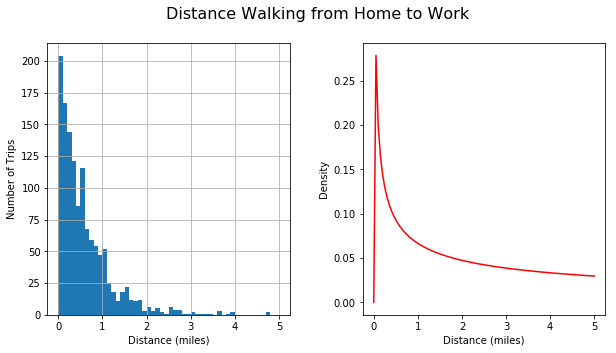

In [20]:
fig = plt.figure(figsize=(10, 5))
ax1 = fig.add_subplot(121)
ax2 = fig.add_subplot(122)
print_walk_df = worker_walk_data[(worker_walk_data.WHYTO == 3) & (worker_walk_data.WHYFROM == 1)]
b, loc, scale = stats.exponpow.fit(print_walk_df.TRPMILES)
if loc < 0.0001:
    loc = 0.0001
x = np.linspace(0, 5, 100)
ax1.set_xlabel("Distance (miles)")
ax1.set_ylabel("Number of Trips")
ax2.set_xlabel("Distance (miles)")
ax2.set_ylabel("Density")
ax2.plot(x, stats.exponpow.pdf(x, b, loc, scale), color='red')
print_walk_df.hist(column="TRPMILES", bins=50, range=(0, 5), ax=ax1)
ax1.set_title("")
fig.suptitle("Distance Walking from Home to Work", fontsize=16)
fig.savefig("distributions/walk1.png")

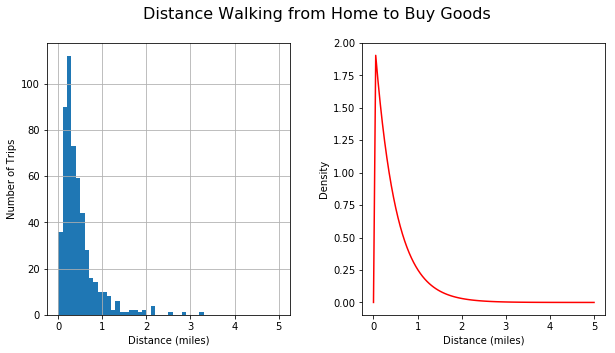

In [21]:
fig = plt.figure(figsize=(10, 5))
ax1 = fig.add_subplot(121)
ax2 = fig.add_subplot(122)
print_walk_df = worker_walk_data[(worker_walk_data.WHYTO == 11) & (worker_walk_data.WHYFROM == 1)]
loc, scale = stats.expon.fit(print_walk_df.TRPMILES)
if loc < 0.0001:
    loc = 0.0001
x = np.linspace(0, 5, 100)
ax1.set_xlabel("Distance (miles)")
ax1.set_ylabel("Number of Trips")
ax2.set_xlabel("Distance (miles)")
ax2.set_ylabel("Density")
ax2.plot(x, stats.expon.pdf(x, loc, scale), color='red')
print_walk_df.hist(column="TRPMILES", bins=50,figsize=(7,7), range=(0, 5),ax=ax1)
ax1.set_title("")
fig.suptitle("Distance Walking from Home to Buy Goods", fontsize=16)
fig.savefig("distributions/walk2.png")

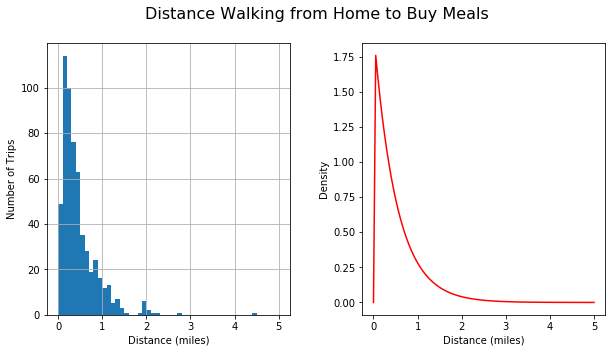

In [22]:
fig = plt.figure(figsize=(10, 5))
ax1 = fig.add_subplot(121)
ax2 = fig.add_subplot(122)
print_walk_df = worker_walk_data[(worker_walk_data.WHYTO == 13) & (worker_walk_data.WHYFROM == 1)]
loc, scale = stats.expon.fit(print_walk_df.TRPMILES)
if loc < 0.0001:
    loc = 0.0001
x = np.linspace(0, 5, 100)
ax1.set_xlabel("Distance (miles)")
ax1.set_ylabel("Number of Trips")
ax2.set_xlabel("Distance (miles)")
ax2.set_ylabel("Density")
ax2.plot(x, stats.expon.pdf(x, loc, scale), color='red')
print_walk_df.hist(column="TRPMILES", bins=50,figsize=(7,7), range=(0, 5), ax=ax1)
ax1.set_title("")
fig.suptitle("Distance Walking from Home to Buy Meals", fontsize=16)
fig.savefig("distributions/walk3.png")

In [23]:
"""
fig = plt.figure(figsize=(10, 5))
ax1 = fig.add_subplot(121)
ax2 = fig.add_subplot(122)
print_walk_df = worker_walk_data[(worker_walk_data.WHYTO == 1) & (worker_walk_data.WHYFROM == 3)]
b, loc, scale = stats.exponpow.fit(print_walk_df.TRPMILES)
if loc < 0.001:
    loc = 0.001
x = np.linspace(0, 5, 100)
ax1.set_xlabel("Distance (miles)")
ax1.set_ylabel("Number of Trips")
ax2.set_xlabel("Distance (miles)")
ax2.set_ylabel("Density")
ax2.plot(x, stats.exponpow.pdf(x, b, loc, scale), color='red')
print_walk_df.hist(column="TRPMILES", bins=50,figsize=(7,7), range=(0, 5), ax=ax1)
ax1.set_title("")
fig.suptitle("Distance Walking from Work to Home", fontsize=16)
fig.savefig("walk4.png")
"""

'\nfig = plt.figure(figsize=(10, 5))\nax1 = fig.add_subplot(121)\nax2 = fig.add_subplot(122)\nprint_walk_df = worker_walk_data[(worker_walk_data.WHYTO == 1) & (worker_walk_data.WHYFROM == 3)]\nb, loc, scale = stats.exponpow.fit(print_walk_df.TRPMILES)\nif loc < 0.001:\n    loc = 0.001\nx = np.linspace(0, 5, 100)\nax1.set_xlabel("Distance (miles)")\nax1.set_ylabel("Number of Trips")\nax2.set_xlabel("Distance (miles)")\nax2.set_ylabel("Density")\nax2.plot(x, stats.exponpow.pdf(x, b, loc, scale), color=\'red\')\nprint_walk_df.hist(column="TRPMILES", bins=50,figsize=(7,7), range=(0, 5), ax=ax1)\nax1.set_title("")\nfig.suptitle("Distance Walking from Work to Home", fontsize=16)\nfig.savefig("walk4.png")\n'

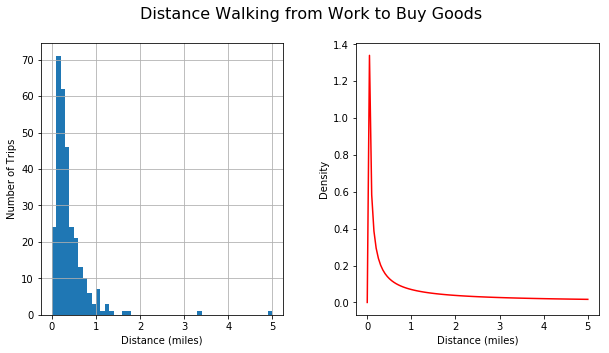

In [24]:
fig = plt.figure(figsize=(10, 5))
ax1 = fig.add_subplot(121)
ax2 = fig.add_subplot(122)
print_walk_df = worker_walk_data[(worker_walk_data.WHYTO == 11) & (worker_walk_data.WHYFROM == 3)]
b, loc, scale = stats.exponpow.fit(print_walk_df.TRPMILES)
if loc < 0.0001:
    loc = 0.0001
x = np.linspace(0, 5, 100)
ax1.set_xlabel("Distance (miles)")
ax1.set_ylabel("Number of Trips")
ax2.set_xlabel("Distance (miles)")
ax2.set_ylabel("Density")
ax2.plot(x, stats.exponpow.pdf(x, b, loc, scale), color='red')
print_walk_df.hist(column="TRPMILES", bins=50,figsize=(7,7), range=(0, 5), ax=ax1)
ax1.set_title("")
fig.suptitle("Distance Walking from Work to Buy Goods", fontsize=16)
fig.savefig("distributions/walk4.png")

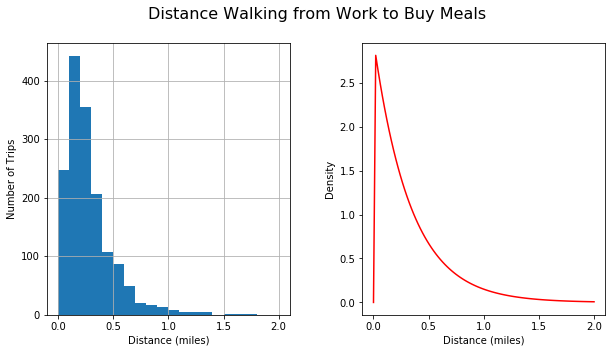

In [25]:
fig = plt.figure(figsize=(10, 5))
ax1 = fig.add_subplot(121)
ax2 = fig.add_subplot(122)
print_walk_df = worker_walk_data[(worker_walk_data.WHYTO == 13) & (worker_walk_data.WHYFROM == 3)]
loc, scale = stats.expon.fit(print_walk_df.TRPMILES)
if loc < 0.0001:
    loc = 0.0001
x = np.linspace(0, 2, 100)
ax1.set_xlabel("Distance (miles)")
ax1.set_ylabel("Number of Trips")
ax2.set_xlabel("Distance (miles)")
ax2.set_ylabel("Density")
ax2.plot(x, stats.expon.pdf(x, loc, scale), color='red')

print_walk_df.hist(column="TRPMILES", bins=20,figsize=(7,7), range=(0, 2), ax=ax1)
ax1.set_title("")
fig.suptitle("Distance Walking from Work to Buy Meals", fontsize=16)
fig.savefig("distributions/walk5.png")

In [26]:
"""
fig = plt.figure(figsize=(10, 5))
ax1 = fig.add_subplot(121)
ax2 = fig.add_subplot(122)
print_walk_df = worker_walk_data[(worker_walk_data.WHYTO == 1) & (worker_walk_data.WHYFROM == 11)]
loc, scale = stats.expon.fit(print_walk_df.TRPMILES)
if loc < 0.001:
    loc = 0.001
x = np.linspace(0, 4, 100)
ax1.set_xlabel("Distance (miles)")
ax1.set_ylabel("Number of Trips")
ax2.set_xlabel("Distance (miles)")
ax2.set_ylabel("Density")
ax2.plot(x, stats.expon.pdf(x, loc, scale), color='red')

print_walk_df.hist(column="TRPMILES", bins=40,figsize=(7,7), range=(0, 4), ax=ax1)
ax1.set_title("")
fig.suptitle("Distance Walking from Buying Goods to Home", fontsize=16)
fig.savefig("walk7.png")
"""

'\nfig = plt.figure(figsize=(10, 5))\nax1 = fig.add_subplot(121)\nax2 = fig.add_subplot(122)\nprint_walk_df = worker_walk_data[(worker_walk_data.WHYTO == 1) & (worker_walk_data.WHYFROM == 11)]\nloc, scale = stats.expon.fit(print_walk_df.TRPMILES)\nif loc < 0.001:\n    loc = 0.001\nx = np.linspace(0, 4, 100)\nax1.set_xlabel("Distance (miles)")\nax1.set_ylabel("Number of Trips")\nax2.set_xlabel("Distance (miles)")\nax2.set_ylabel("Density")\nax2.plot(x, stats.expon.pdf(x, loc, scale), color=\'red\')\n\nprint_walk_df.hist(column="TRPMILES", bins=40,figsize=(7,7), range=(0, 4), ax=ax1)\nax1.set_title("")\nfig.suptitle("Distance Walking from Buying Goods to Home", fontsize=16)\nfig.savefig("walk7.png")\n'

In [27]:
"""
fig = plt.figure(figsize=(10, 5))
ax1 = fig.add_subplot(121)
ax2 = fig.add_subplot(122)
print_walk_df = worker_walk_data[(worker_walk_data.WHYTO == 3) & (worker_walk_data.WHYFROM == 11)]
loc, scale = stats.expon.fit(print_walk_df.TRPMILES)
if loc < 0.001:
    loc = 0.001
x = np.linspace(0, 2, 100)
ax1.set_xlabel("Distance (miles)")
ax1.set_ylabel("Number of Trips")
ax2.set_xlabel("Distance (miles)")
ax2.set_ylabel("Density")
ax2.plot(x, stats.expon.pdf(x, loc, scale), color='red')

print_walk_df.hist(column="TRPMILES", bins=20,figsize=(7,7), range=(0, 2), ax=ax1)
ax1.set_title("")
fig.suptitle("Distance Walking from Buying Goods to Work", fontsize=16)
fig.savefig("walk8.png")
"""

'\nfig = plt.figure(figsize=(10, 5))\nax1 = fig.add_subplot(121)\nax2 = fig.add_subplot(122)\nprint_walk_df = worker_walk_data[(worker_walk_data.WHYTO == 3) & (worker_walk_data.WHYFROM == 11)]\nloc, scale = stats.expon.fit(print_walk_df.TRPMILES)\nif loc < 0.001:\n    loc = 0.001\nx = np.linspace(0, 2, 100)\nax1.set_xlabel("Distance (miles)")\nax1.set_ylabel("Number of Trips")\nax2.set_xlabel("Distance (miles)")\nax2.set_ylabel("Density")\nax2.plot(x, stats.expon.pdf(x, loc, scale), color=\'red\')\n\nprint_walk_df.hist(column="TRPMILES", bins=20,figsize=(7,7), range=(0, 2), ax=ax1)\nax1.set_title("")\nfig.suptitle("Distance Walking from Buying Goods to Work", fontsize=16)\nfig.savefig("walk8.png")\n'

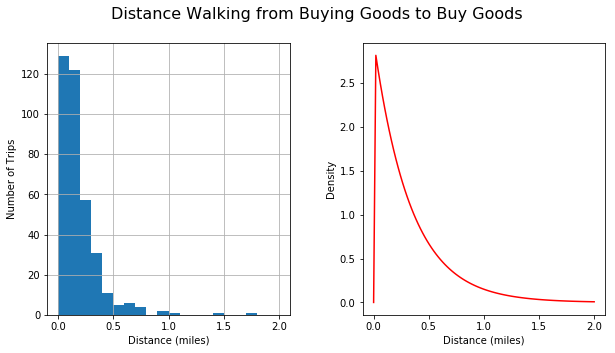

In [28]:
fig = plt.figure(figsize=(10, 5))
ax1 = fig.add_subplot(121)
ax2 = fig.add_subplot(122)
print_walk_df = worker_walk_data[(worker_walk_data.WHYTO == 11) & (worker_walk_data.WHYFROM == 11)]
loc, scale = stats.expon.fit(print_walk_df.TRPMILES)
if loc < 0.0001:
    loc = 0.0001
x = np.linspace(0, 2, 100)
ax1.set_xlabel("Distance (miles)")
ax1.set_ylabel("Number of Trips")
ax2.set_xlabel("Distance (miles)")
ax2.set_ylabel("Density")
ax2.plot(x, stats.expon.pdf(x, loc, scale), color='red')

print_walk_df.hist(column="TRPMILES", bins=20,figsize=(7,7), range=(0, 2), ax=ax1)
ax1.set_title("")
fig.suptitle("Distance Walking from Buying Goods to Buy Goods", fontsize=16)
fig.savefig("distributions/walk6.png")

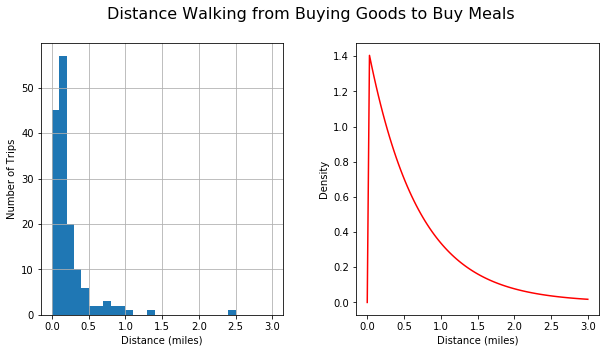

In [29]:
fig = plt.figure(figsize=(10, 5))
ax1 = fig.add_subplot(121)
ax2 = fig.add_subplot(122)
print_walk_df = worker_walk_data[(worker_walk_data.WHYTO == 13) & (worker_walk_data.WHYFROM == 11)]
loc, scale = stats.expon.fit(print_walk_df.TRPMILES)
if loc < 0.0001:
    loc = 0.0001
x = np.linspace(0, 3, 100)
ax1.set_xlabel("Distance (miles)")
ax1.set_ylabel("Number of Trips")
ax2.set_xlabel("Distance (miles)")
ax2.set_ylabel("Density")
ax2.plot(x, stats.expon.pdf(x, loc, scale), color='red')

print_walk_df.hist(column="TRPMILES", bins=30,figsize=(7,7), range=(0, 3), ax=ax1)
ax1.set_title("")
fig.suptitle("Distance Walking from Buying Goods to Buy Meals", fontsize=16)
fig.savefig("distributions/walk7.png")

In [30]:
"""
fig = plt.figure(figsize=(10, 5))
ax1 = fig.add_subplot(121)
ax2 = fig.add_subplot(122)
print_walk_df = worker_walk_data[(worker_walk_data.WHYTO == 1) & (worker_walk_data.WHYFROM == 13)]
loc, scale = stats.expon.fit(print_walk_df.TRPMILES)
if loc < 0.001:
    loc = 0.001
x = np.linspace(0, 3, 100)
ax1.set_xlabel("Distance (miles)")
ax1.set_ylabel("Number of Trips")
ax2.set_xlabel("Distance (miles)")
ax2.set_ylabel("Density")
ax2.plot(x, stats.expon.pdf(x, loc, scale), color='red')

print_walk_df.hist(column="TRPMILES", bins=30,figsize=(7,7), range=(0, 3), ax=ax1)
ax1.set_title("")
fig.suptitle("Distance Walking from Buying Meals to Home", fontsize=16)
fig.savefig("walk11.png")
"""

'\nfig = plt.figure(figsize=(10, 5))\nax1 = fig.add_subplot(121)\nax2 = fig.add_subplot(122)\nprint_walk_df = worker_walk_data[(worker_walk_data.WHYTO == 1) & (worker_walk_data.WHYFROM == 13)]\nloc, scale = stats.expon.fit(print_walk_df.TRPMILES)\nif loc < 0.001:\n    loc = 0.001\nx = np.linspace(0, 3, 100)\nax1.set_xlabel("Distance (miles)")\nax1.set_ylabel("Number of Trips")\nax2.set_xlabel("Distance (miles)")\nax2.set_ylabel("Density")\nax2.plot(x, stats.expon.pdf(x, loc, scale), color=\'red\')\n\nprint_walk_df.hist(column="TRPMILES", bins=30,figsize=(7,7), range=(0, 3), ax=ax1)\nax1.set_title("")\nfig.suptitle("Distance Walking from Buying Meals to Home", fontsize=16)\nfig.savefig("walk11.png")\n'

In [31]:
"""
fig = plt.figure(figsize=(10, 5))
ax1 = fig.add_subplot(121)
ax2 = fig.add_subplot(122)
print_walk_df = worker_walk_data[(worker_walk_data.WHYTO == 3) & (worker_walk_data.WHYFROM == 13)]
loc, scale = stats.expon.fit(print_walk_df.TRPMILES)
if loc < 0.001:
    loc = 0.001
x = np.linspace(0, 2, 100)
ax1.set_xlabel("Distance (miles)")
ax1.set_ylabel("Number of Trips")
ax2.set_xlabel("Distance (miles)")
ax2.set_ylabel("Density")
ax2.plot(x, stats.expon.pdf(x, loc, scale), color='red')

print_walk_df.hist(column="TRPMILES", bins=20,figsize=(7,7), range=(0, 2), ax=ax1)
ax1.set_title("")
fig.suptitle("Distance Walking from Buying Meals to Work", fontsize=16)
fig.savefig("walk12.png")
"""

'\nfig = plt.figure(figsize=(10, 5))\nax1 = fig.add_subplot(121)\nax2 = fig.add_subplot(122)\nprint_walk_df = worker_walk_data[(worker_walk_data.WHYTO == 3) & (worker_walk_data.WHYFROM == 13)]\nloc, scale = stats.expon.fit(print_walk_df.TRPMILES)\nif loc < 0.001:\n    loc = 0.001\nx = np.linspace(0, 2, 100)\nax1.set_xlabel("Distance (miles)")\nax1.set_ylabel("Number of Trips")\nax2.set_xlabel("Distance (miles)")\nax2.set_ylabel("Density")\nax2.plot(x, stats.expon.pdf(x, loc, scale), color=\'red\')\n\nprint_walk_df.hist(column="TRPMILES", bins=20,figsize=(7,7), range=(0, 2), ax=ax1)\nax1.set_title("")\nfig.suptitle("Distance Walking from Buying Meals to Work", fontsize=16)\nfig.savefig("walk12.png")\n'

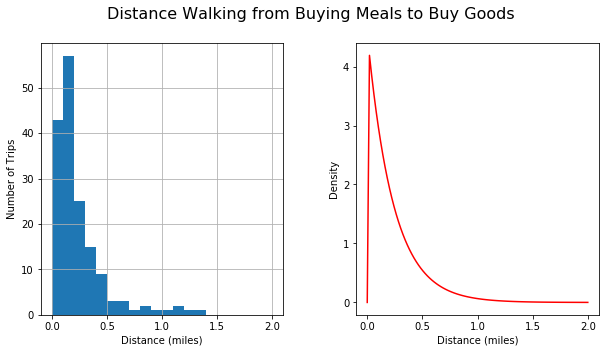

In [32]:
fig = plt.figure(figsize=(10, 5))
ax1 = fig.add_subplot(121)
ax2 = fig.add_subplot(122)
print_walk_df = worker_walk_data[(worker_walk_data.WHYTO == 11) & (worker_walk_data.WHYFROM == 13)]
loc, scale = stats.expon.fit(print_walk_df.TRPMILES)
if loc < 0.0001:
    loc = 0.0001
x = np.linspace(0, 2, 100)
ax1.set_xlabel("Distance (miles)")
ax1.set_ylabel("Number of Trips")
ax2.set_xlabel("Distance (miles)")
ax2.set_ylabel("Density")
ax2.plot(x, stats.expon.pdf(x, loc, scale), color='red')

print_walk_df.hist(column="TRPMILES", bins=20,figsize=(7,7), range=(0, 2), ax=ax1)
ax1.set_title("")
fig.suptitle("Distance Walking from Buying Meals to Buy Goods", fontsize=16)
fig.savefig("distributions/walk8.png")

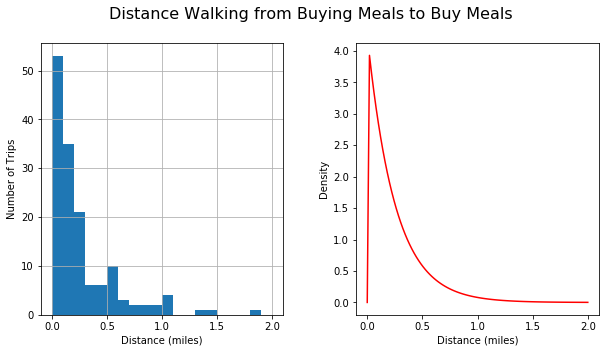

In [33]:
fig = plt.figure(figsize=(10, 5))
ax1 = fig.add_subplot(121)
ax2 = fig.add_subplot(122)
print_walk_df = worker_walk_data[(worker_walk_data.WHYTO == 13) & (worker_walk_data.WHYFROM == 13)]
loc, scale = stats.expon.fit(print_walk_df.TRPMILES)
if loc < 0.0001:
    loc = 0.0001
x = np.linspace(0, 2, 100)
ax1.set_xlabel("Distance (miles)")
ax1.set_ylabel("Number of Trips")
ax2.set_xlabel("Distance (miles)")
ax2.set_ylabel("Density")
ax2.plot(x, stats.expon.pdf(x, loc, scale), color='red')

print_walk_df.hist(column="TRPMILES", bins=20,figsize=(7,7), range=(0, 2), ax=ax1)
ax1.set_title("")
fig.suptitle("Distance Walking from Buying Meals to Buy Meals", fontsize=16)
fig.savefig("distributions/walk9.png")

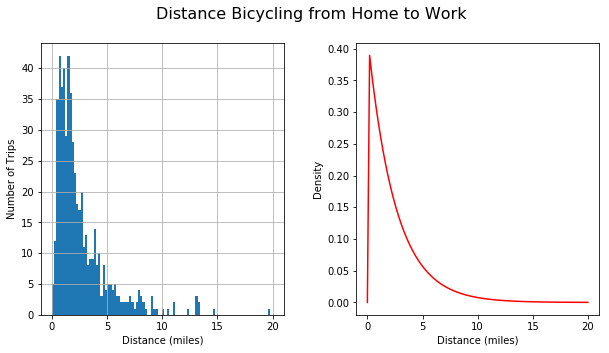

In [34]:
fig = plt.figure(figsize=(10, 5))
ax1 = fig.add_subplot(121)
ax2 = fig.add_subplot(122)
print_bike_df = worker_bike_data[(worker_bike_data.WHYTO == 3) & (worker_bike_data.WHYFROM == 1)]
loc, scale = stats.expon.fit(print_bike_df.TRPMILES)
if loc < 0.0001:
    loc = 0.0001
x = np.linspace(0, 20, 100)
ax1.set_xlabel("Distance (miles)")
ax1.set_ylabel("Number of Trips")
ax2.set_xlabel("Distance (miles)")
ax2.set_ylabel("Density")
ax2.plot(x, stats.expon.pdf(x, loc, scale), color='red')
print_bike_df.hist(column="TRPMILES", bins=100, range=(0, 20), ax=ax1)
ax1.set_title("")
fig.suptitle("Distance Bicycling from Home to Work", fontsize=16)
fig.savefig("distributions/bike1.png")

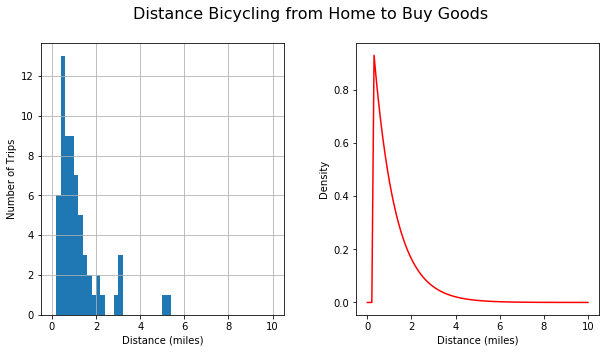

In [35]:
fig = plt.figure(figsize=(10, 5))
ax1 = fig.add_subplot(121)
ax2 = fig.add_subplot(122)
print_bike_df = worker_bike_data[(worker_bike_data.WHYTO == 11) & (worker_bike_data.WHYFROM == 1)]
loc, scale = stats.expon.fit(print_bike_df.TRPMILES)
if loc < 0.0001:
    loc = 0.0001
x = np.linspace(0, 10, 100)
ax1.set_xlabel("Distance (miles)")
ax1.set_ylabel("Number of Trips")
ax2.set_xlabel("Distance (miles)")
ax2.set_ylabel("Density")
ax2.plot(x, stats.expon.pdf(x, loc, scale), color='red')
print_bike_df.hist(column="TRPMILES", bins=50, range=(0, 10), ax=ax1)
ax1.set_title("")
fig.suptitle("Distance Bicycling from Home to Buy Goods", fontsize=16)
fig.savefig("distributions/bike2.png")

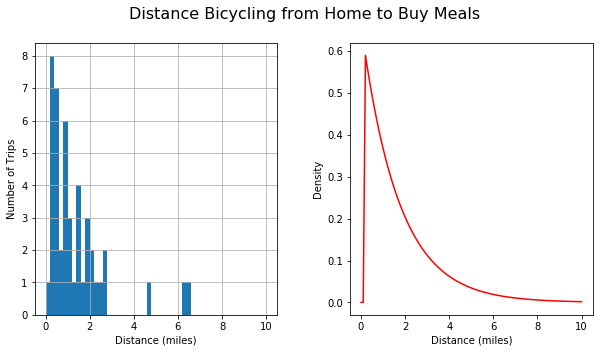

In [36]:
fig = plt.figure(figsize=(10, 5))
ax1 = fig.add_subplot(121)
ax2 = fig.add_subplot(122)
print_bike_df = worker_bike_data[(worker_bike_data.WHYTO == 13) & (worker_bike_data.WHYFROM == 1)]
loc, scale = stats.expon.fit(print_bike_df.TRPMILES)
if loc < 0.0001:
    loc = 0.0001
x = np.linspace(0, 10, 100)
ax1.set_xlabel("Distance (miles)")
ax1.set_ylabel("Number of Trips")
ax2.set_xlabel("Distance (miles)")
ax2.set_ylabel("Density")
ax2.plot(x, stats.expon.pdf(x, loc, scale), color='red')
print_bike_df.hist(column="TRPMILES", bins=50, range=(0, 10), ax=ax1)
ax1.set_title("")
fig.suptitle("Distance Bicycling from Home to Buy Meals", fontsize=16)
fig.savefig("distributions/bike3.png")

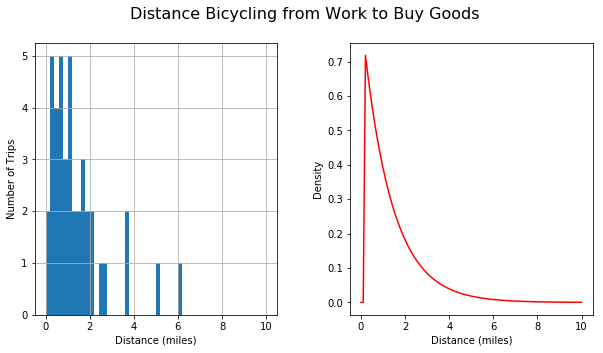

In [37]:
fig = plt.figure(figsize=(10, 5))
ax1 = fig.add_subplot(121)
ax2 = fig.add_subplot(122)
print_bike_df = worker_bike_data[(worker_bike_data.WHYTO == 11) & (worker_bike_data.WHYFROM == 3)]
loc, scale = stats.expon.fit(print_bike_df.TRPMILES)
if loc < 0.0001:
    loc = 0.0001
x = np.linspace(0, 10, 100)
ax1.set_xlabel("Distance (miles)")
ax1.set_ylabel("Number of Trips")
ax2.set_xlabel("Distance (miles)")
ax2.set_ylabel("Density")
ax2.plot(x, stats.expon.pdf(x, loc, scale), color='red')
print_bike_df.hist(column="TRPMILES", bins=50, range=(0, 10), ax=ax1)
ax1.set_title("")
fig.suptitle("Distance Bicycling from Work to Buy Goods", fontsize=16)
fig.savefig("distributions/bike4.png")

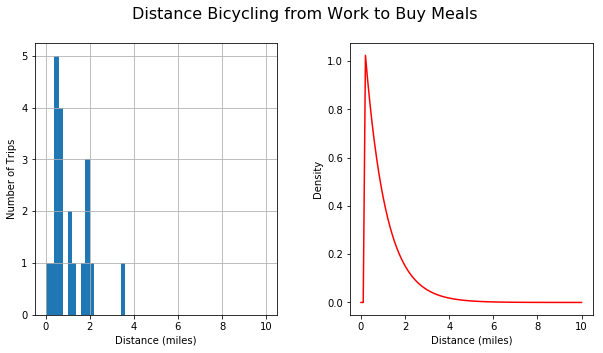

In [38]:
fig = plt.figure(figsize=(10, 5))
ax1 = fig.add_subplot(121)
ax2 = fig.add_subplot(122)
print_bike_df = worker_bike_data[(worker_bike_data.WHYTO == 13) & (worker_bike_data.WHYFROM == 3)]
loc, scale = stats.expon.fit(print_bike_df.TRPMILES)
if loc < 0.0001:
    loc = 0.0001
x = np.linspace(0, 10, 100)
ax1.set_xlabel("Distance (miles)")
ax1.set_ylabel("Number of Trips")
ax2.set_xlabel("Distance (miles)")
ax2.set_ylabel("Density")
ax2.plot(x, stats.expon.pdf(x, loc, scale), color='red')
print_bike_df.hist(column="TRPMILES", bins=50, range=(0, 10), ax=ax1)
ax1.set_title("")
fig.suptitle("Distance Bicycling from Work to Buy Meals", fontsize=16)
fig.savefig("distributions/bike5.png")

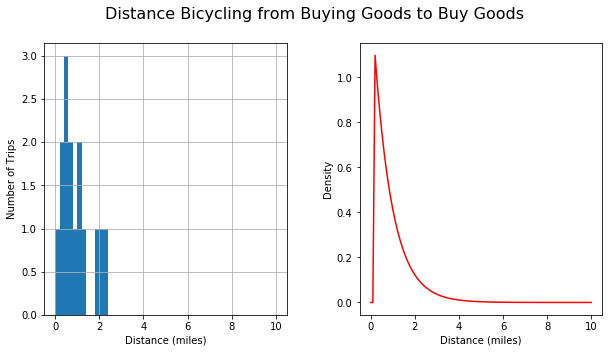

In [39]:
fig = plt.figure(figsize=(10, 5))
ax1 = fig.add_subplot(121)
ax2 = fig.add_subplot(122)
print_bike_df = worker_bike_data[(worker_bike_data.WHYTO == 11) & (worker_bike_data.WHYFROM == 11)]
loc, scale = stats.expon.fit(print_bike_df.TRPMILES)
if loc < 0.0001:
    loc = 0.0001
x = np.linspace(0, 10, 100)
ax1.set_xlabel("Distance (miles)")
ax1.set_ylabel("Number of Trips")
ax2.set_xlabel("Distance (miles)")
ax2.set_ylabel("Density")
ax2.plot(x, stats.expon.pdf(x, loc, scale), color='red')
print_bike_df.hist(column="TRPMILES", bins=50, range=(0, 10), ax=ax1)
ax1.set_title("")
fig.suptitle("Distance Bicycling from Buying Goods to Buy Goods", fontsize=16)
fig.savefig("distributions/bike6.png")

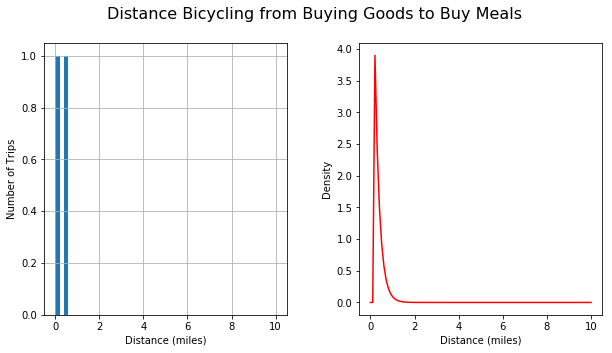

In [40]:
fig = plt.figure(figsize=(10, 5))
ax1 = fig.add_subplot(121)
ax2 = fig.add_subplot(122)
print_bike_df = worker_bike_data[(worker_bike_data.WHYTO == 13) & (worker_bike_data.WHYFROM == 11)]
loc, scale = stats.expon.fit(print_bike_df.TRPMILES)
if loc < 0.0001:
    loc = 0.0001
x = np.linspace(0, 10, 100)
ax1.set_xlabel("Distance (miles)")
ax1.set_ylabel("Number of Trips")
ax2.set_xlabel("Distance (miles)")
ax2.set_ylabel("Density")
ax2.plot(x, stats.expon.pdf(x, loc, scale), color='red')
print_bike_df.hist(column="TRPMILES", bins=50, range=(0, 10), ax=ax1)
ax1.set_title("")
fig.suptitle("Distance Bicycling from Buying Goods to Buy Meals", fontsize=16)
fig.savefig("distributions/bike7.png")

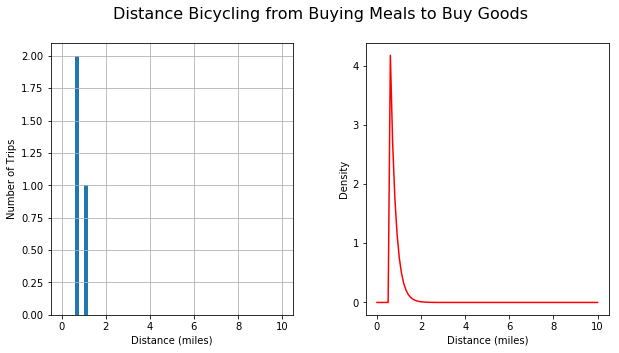

In [41]:
fig = plt.figure(figsize=(10, 5))
ax1 = fig.add_subplot(121)
ax2 = fig.add_subplot(122)
print_bike_df = worker_bike_data[(worker_bike_data.WHYTO == 11) & (worker_bike_data.WHYFROM == 13)]
loc, scale = stats.expon.fit(print_bike_df.TRPMILES)
if loc < 0.0001:
    loc = 0.0001
x = np.linspace(0, 10, 100)
ax1.set_xlabel("Distance (miles)")
ax1.set_ylabel("Number of Trips")
ax2.set_xlabel("Distance (miles)")
ax2.set_ylabel("Density")
ax2.plot(x, stats.expon.pdf(x, loc, scale), color='red')
print_bike_df.hist(column="TRPMILES", bins=50, range=(0, 10), ax=ax1)
ax1.set_title("")
fig.suptitle("Distance Bicycling from Buying Meals to Buy Goods", fontsize=16)
fig.savefig("distributions/bike8.png")

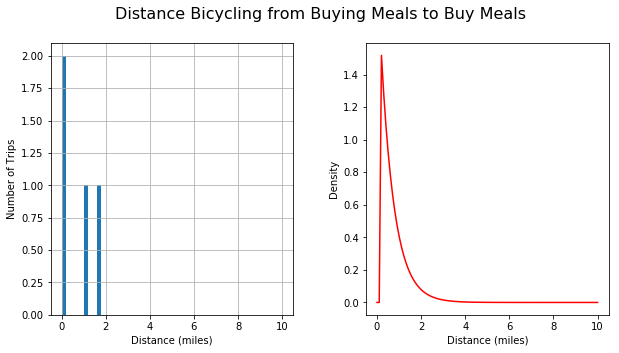

In [42]:
fig = plt.figure(figsize=(10, 5))
ax1 = fig.add_subplot(121)
ax2 = fig.add_subplot(122)
print_bike_df = worker_bike_data[(worker_bike_data.WHYTO == 13) & (worker_bike_data.WHYFROM == 13)]
loc, scale = stats.expon.fit(print_bike_df.TRPMILES)
if loc < 0.0001:
    loc = 0.0001
x = np.linspace(0, 10, 100)
ax1.set_xlabel("Distance (miles)")
ax1.set_ylabel("Number of Trips")
ax2.set_xlabel("Distance (miles)")
ax2.set_ylabel("Density")
ax2.plot(x, stats.expon.pdf(x, loc, scale), color='red')
print_bike_df.hist(column="TRPMILES", bins=50, range=(0, 10), ax=ax1)
ax1.set_title("")
fig.suptitle("Distance Bicycling from Buying Meals to Buy Meals", fontsize=16)
fig.savefig("distributions/bike9.png")

In [43]:
"""
# Generation distribution of trip durations
for i in WHYTO_Options:
    for j in WHYFROM_Options:
        print_walk_df = worker_drive_data[worker_drive_data.WHYTO == i]
        print_walk_df = print_walk_df[print_walk_df.WHYFROM == j]
        print(print_walk_df.shape)
        print_walk_df.hist(column="TRPMILES", bins=100,figsize=(10,10), range=(0, 100))
        plt.title("Driving {} to {}".format(option_names[j], option_names[i]))
"""

'\n# Generation distribution of trip durations\nfor i in WHYTO_Options:\n    for j in WHYFROM_Options:\n        print_walk_df = worker_drive_data[worker_drive_data.WHYTO == i]\n        print_walk_df = print_walk_df[print_walk_df.WHYFROM == j]\n        print(print_walk_df.shape)\n        print_walk_df.hist(column="TRPMILES", bins=100,figsize=(10,10), range=(0, 100))\n        plt.title("Driving {} to {}".format(option_names[j], option_names[i]))\n'

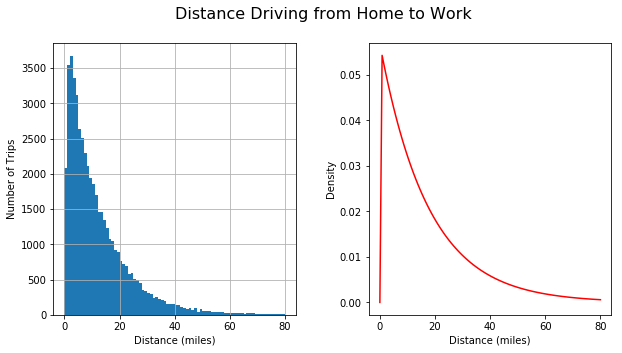

In [44]:
fig = plt.figure(figsize=(10, 5))
ax1 = fig.add_subplot(121)
ax2 = fig.add_subplot(122)
print_drive_df = worker_drive_data[(worker_drive_data.WHYTO == 3) & (worker_drive_data.WHYFROM == 1)]
loc, scale = stats.expon.fit(print_drive_df.TRPMILES)
if loc < 0.0001:
    loc = 0.0001
x = np.linspace(0, 80, 100)
ax1.set_xlabel("Distance (miles)")
ax1.set_ylabel("Number of Trips")
ax2.set_xlabel("Distance (miles)")
ax2.set_ylabel("Density")
ax2.plot(x, stats.expon.pdf(x, loc, scale), color='red')

print_drive_df.hist(column="TRPMILES", bins=80,figsize=(7,7), range=(0, 80), ax=ax1)
ax1.set_title("")
fig.suptitle("Distance Driving from Home to Work", fontsize=16)
fig.savefig("distributions/drive1.png")

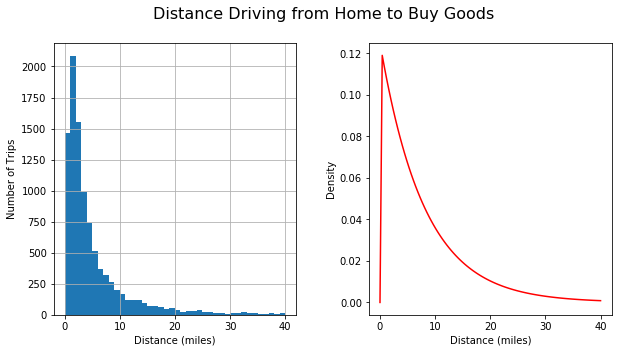

In [45]:
fig = plt.figure(figsize=(10, 5))
ax1 = fig.add_subplot(121)
ax2 = fig.add_subplot(122)
print_drive_df = worker_drive_data[(worker_drive_data.WHYTO == 11) & (worker_drive_data.WHYFROM == 1)]
loc, scale = stats.expon.fit(print_drive_df.TRPMILES)
if loc < 0.0001:
    loc = 0.0001
x = np.linspace(0, 40, 100)
ax1.set_xlabel("Distance (miles)")
ax1.set_ylabel("Number of Trips")
ax2.set_xlabel("Distance (miles)")
ax2.set_ylabel("Density")
ax2.plot(x, stats.expon.pdf(x, loc, scale), color='red')

print_drive_df.hist(column="TRPMILES", bins=40,figsize=(7,7), range=(0, 40), ax=ax1)
ax1.set_title("")
fig.suptitle("Distance Driving from Home to Buy Goods", fontsize=16)
fig.savefig("distributions/drive2.png")

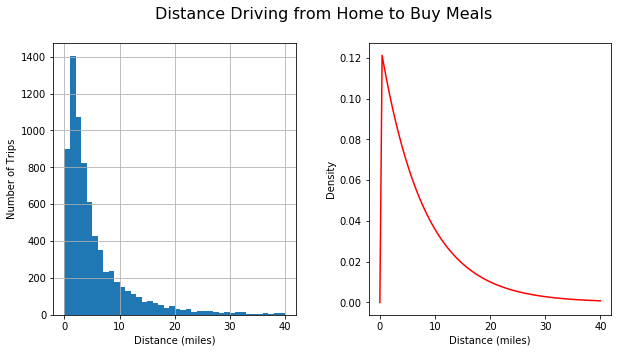

In [46]:
fig = plt.figure(figsize=(10, 5))
ax1 = fig.add_subplot(121)
ax2 = fig.add_subplot(122)
print_drive_df = worker_drive_data[(worker_drive_data.WHYTO == 13) & (worker_drive_data.WHYFROM == 1)]
loc, scale = stats.expon.fit(print_drive_df.TRPMILES)
if loc < 0.0001:
    loc = 0.0001
x = np.linspace(0, 40, 100)
ax1.set_xlabel("Distance (miles)")
ax1.set_ylabel("Number of Trips")
ax2.set_xlabel("Distance (miles)")
ax2.set_ylabel("Density")
ax2.plot(x, stats.expon.pdf(x, loc, scale), color='red')

print_drive_df.hist(column="TRPMILES", bins=40,figsize=(7,7), range=(0, 40), ax=ax1)
ax1.set_title("")
fig.suptitle("Distance Driving from Home to Buy Meals", fontsize=16)
fig.savefig("distributions/drive3.png")

In [47]:
"""
fig = plt.figure(figsize=(10, 5))
ax1 = fig.add_subplot(121)
ax2 = fig.add_subplot(122)
print_drive_df = worker_drive_data[(worker_drive_data.WHYTO == 1) & (worker_drive_data.WHYFROM == 3)]
loc, scale = stats.expon.fit(print_drive_df.TRPMILES)
if loc < 0.001:
    loc = 0.001
x = np.linspace(0, 70, 100)
ax1.set_xlabel("Distance (miles)")
ax1.set_ylabel("Number of Trips")
ax2.set_xlabel("Distance (miles)")
ax2.set_ylabel("Density")
ax2.plot(x, stats.expon.pdf(x, loc, scale), color='red')

print_drive_df.hist(column="TRPMILES", bins=70,figsize=(7,7), range=(0, 70), ax=ax1)
ax1.set_title("")
fig.suptitle("Distance Driving from Work to Home", fontsize=16)
fig.savefig("drive4.png")
"""

'\nfig = plt.figure(figsize=(10, 5))\nax1 = fig.add_subplot(121)\nax2 = fig.add_subplot(122)\nprint_drive_df = worker_drive_data[(worker_drive_data.WHYTO == 1) & (worker_drive_data.WHYFROM == 3)]\nloc, scale = stats.expon.fit(print_drive_df.TRPMILES)\nif loc < 0.001:\n    loc = 0.001\nx = np.linspace(0, 70, 100)\nax1.set_xlabel("Distance (miles)")\nax1.set_ylabel("Number of Trips")\nax2.set_xlabel("Distance (miles)")\nax2.set_ylabel("Density")\nax2.plot(x, stats.expon.pdf(x, loc, scale), color=\'red\')\n\nprint_drive_df.hist(column="TRPMILES", bins=70,figsize=(7,7), range=(0, 70), ax=ax1)\nax1.set_title("")\nfig.suptitle("Distance Driving from Work to Home", fontsize=16)\nfig.savefig("drive4.png")\n'

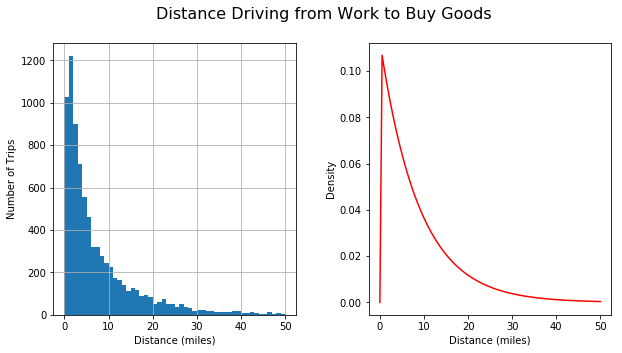

In [48]:
fig = plt.figure(figsize=(10, 5))
ax1 = fig.add_subplot(121)
ax2 = fig.add_subplot(122)
print_drive_df = worker_drive_data[(worker_drive_data.WHYTO == 11) & (worker_drive_data.WHYFROM == 3)]
loc, scale = stats.expon.fit(print_drive_df.TRPMILES)
if loc < 0.0001:
    loc = 0.0001
x = np.linspace(0, 50, 100)
ax1.set_xlabel("Distance (miles)")
ax1.set_ylabel("Number of Trips")
ax2.set_xlabel("Distance (miles)")
ax2.set_ylabel("Density")
ax2.plot(x, stats.expon.pdf(x, loc, scale), color='red')

print_drive_df.hist(column="TRPMILES", bins=50,figsize=(7,7), range=(0, 50), ax=ax1)
ax1.set_title("")
fig.suptitle("Distance Driving from Work to Buy Goods", fontsize=16)
fig.savefig("distributions/drive4.png")

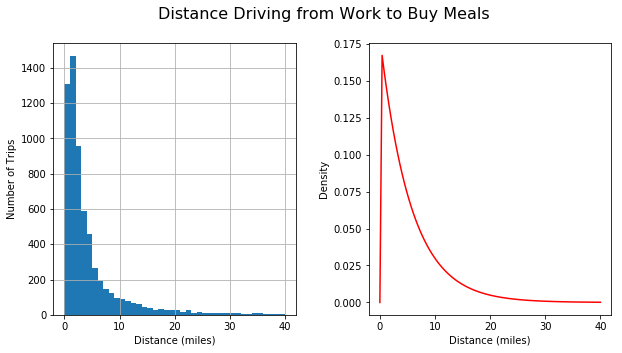

In [49]:
fig = plt.figure(figsize=(10, 5))
ax1 = fig.add_subplot(121)
ax2 = fig.add_subplot(122)
print_drive_df = worker_drive_data[(worker_drive_data.WHYTO == 13) & (worker_drive_data.WHYFROM == 3)]
loc, scale = stats.expon.fit(print_drive_df.TRPMILES)
if loc < 0.0001:
    loc = 0.0001
x = np.linspace(0, 40, 100)
ax1.set_xlabel("Distance (miles)")
ax1.set_ylabel("Number of Trips")
ax2.set_xlabel("Distance (miles)")
ax2.set_ylabel("Density")
ax2.plot(x, stats.expon.pdf(x, loc, scale), color='red')

print_drive_df.hist(column="TRPMILES", bins=40,figsize=(7,7), range=(0, 40), ax=ax1)
ax1.set_title("")
fig.suptitle("Distance Driving from Work to Buy Meals", fontsize=16)
fig.savefig("distributions/drive5.png")

In [50]:
"""
fig = plt.figure(figsize=(10, 5))
ax1 = fig.add_subplot(121)
ax2 = fig.add_subplot(122)
print_drive_df = worker_drive_data[(worker_drive_data.WHYTO == 1) & (worker_drive_data.WHYFROM == 11)]
loc, scale = stats.expon.fit(print_drive_df.TRPMILES)
if loc < 0.001:
    loc = 0.001
x = np.linspace(0, 50, 100)
ax1.set_xlabel("Distance (miles)")
ax1.set_ylabel("Number of Trips")
ax2.set_xlabel("Distance (miles)")
ax2.set_ylabel("Density")
ax2.plot(x, stats.expon.pdf(x, loc, scale), color='red')

print_drive_df.hist(column="TRPMILES", bins=50,figsize=(7,7), range=(0, 50), ax=ax1)
ax1.set_title("")
fig.suptitle("Distance Driving from Buying Goods to Home", fontsize=16)
fig.savefig("drive7.png")
"""

'\nfig = plt.figure(figsize=(10, 5))\nax1 = fig.add_subplot(121)\nax2 = fig.add_subplot(122)\nprint_drive_df = worker_drive_data[(worker_drive_data.WHYTO == 1) & (worker_drive_data.WHYFROM == 11)]\nloc, scale = stats.expon.fit(print_drive_df.TRPMILES)\nif loc < 0.001:\n    loc = 0.001\nx = np.linspace(0, 50, 100)\nax1.set_xlabel("Distance (miles)")\nax1.set_ylabel("Number of Trips")\nax2.set_xlabel("Distance (miles)")\nax2.set_ylabel("Density")\nax2.plot(x, stats.expon.pdf(x, loc, scale), color=\'red\')\n\nprint_drive_df.hist(column="TRPMILES", bins=50,figsize=(7,7), range=(0, 50), ax=ax1)\nax1.set_title("")\nfig.suptitle("Distance Driving from Buying Goods to Home", fontsize=16)\nfig.savefig("drive7.png")\n'

In [51]:
"""
fig = plt.figure(figsize=(10, 5))
ax1 = fig.add_subplot(121)
ax2 = fig.add_subplot(122)
print_drive_df = worker_drive_data[(worker_drive_data.WHYTO == 3) & (worker_drive_data.WHYFROM == 11)]
loc, scale = stats.expon.fit(print_drive_df.TRPMILES)
if loc < 0.001:
    loc = 0.001
x = np.linspace(0, 40, 100)
ax1.set_xlabel("Distance (miles)")
ax1.set_ylabel("Number of Trips")
ax2.set_xlabel("Distance (miles)")
ax2.set_ylabel("Density")
ax2.plot(x, stats.expon.pdf(x, loc, scale), color='red')

print_drive_df.hist(column="TRPMILES", bins=40,figsize=(7,7), range=(0, 40), ax=ax1)
ax1.set_title("")
fig.suptitle("Distance Driving from Buying Goods to Work", fontsize=16)
fig.savefig("drive8.png")
"""

'\nfig = plt.figure(figsize=(10, 5))\nax1 = fig.add_subplot(121)\nax2 = fig.add_subplot(122)\nprint_drive_df = worker_drive_data[(worker_drive_data.WHYTO == 3) & (worker_drive_data.WHYFROM == 11)]\nloc, scale = stats.expon.fit(print_drive_df.TRPMILES)\nif loc < 0.001:\n    loc = 0.001\nx = np.linspace(0, 40, 100)\nax1.set_xlabel("Distance (miles)")\nax1.set_ylabel("Number of Trips")\nax2.set_xlabel("Distance (miles)")\nax2.set_ylabel("Density")\nax2.plot(x, stats.expon.pdf(x, loc, scale), color=\'red\')\n\nprint_drive_df.hist(column="TRPMILES", bins=40,figsize=(7,7), range=(0, 40), ax=ax1)\nax1.set_title("")\nfig.suptitle("Distance Driving from Buying Goods to Work", fontsize=16)\nfig.savefig("drive8.png")\n'

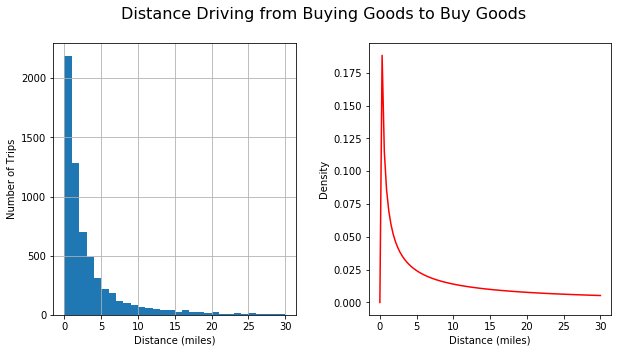

In [52]:
fig = plt.figure(figsize=(10, 5))
ax1 = fig.add_subplot(121)
ax2 = fig.add_subplot(122)
print_drive_df = worker_drive_data[(worker_drive_data.WHYTO == 11) & (worker_drive_data.WHYFROM == 11)]
b, loc, scale = stats.exponpow.fit(print_drive_df.TRPMILES)
if loc < 0.0001:
    loc = 0.0001
x = np.linspace(0, 30, 100)
ax1.set_xlabel("Distance (miles)")
ax1.set_ylabel("Number of Trips")
ax2.set_xlabel("Distance (miles)")
ax2.set_ylabel("Density")
ax2.plot(x, stats.exponpow.pdf(x, b, loc, scale), color='red')

print_drive_df.hist(column="TRPMILES", bins=30,figsize=(7,7), range=(0, 30), ax=ax1)
ax1.set_title("")
fig.suptitle("Distance Driving from Buying Goods to Buy Goods", fontsize=16)
fig.savefig("distributions/drive6.png")

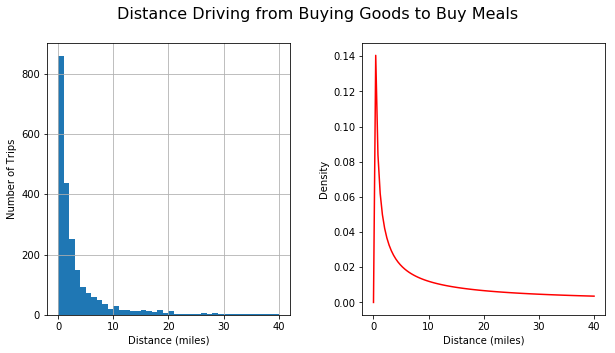

In [53]:
fig = plt.figure(figsize=(10, 5))
ax1 = fig.add_subplot(121)
ax2 = fig.add_subplot(122)
print_drive_df = worker_drive_data[(worker_drive_data.WHYTO == 13) & (worker_drive_data.WHYFROM == 11)]
b, loc, scale = stats.exponpow.fit(print_drive_df.TRPMILES)
if loc < 0.0001:
    loc = 0.0001
x = np.linspace(0, 40, 100)
ax1.set_xlabel("Distance (miles)")
ax1.set_ylabel("Number of Trips")
ax2.set_xlabel("Distance (miles)")
ax2.set_ylabel("Density")
ax2.plot(x, stats.exponpow.pdf(x, b, loc, scale), color='red')

print_drive_df.hist(column="TRPMILES", bins=40,figsize=(7,7), range=(0, 40), ax=ax1)
ax1.set_title("")
fig.suptitle("Distance Driving from Buying Goods to Buy Meals", fontsize=16)
fig.savefig("distributions/drive7.png")

In [54]:
"""
fig = plt.figure(figsize=(10, 5))
ax1 = fig.add_subplot(121)
ax2 = fig.add_subplot(122)
print_drive_df = worker_drive_data[(worker_drive_data.WHYTO == 1) & (worker_drive_data.WHYFROM == 13)]
loc, scale = stats.expon.fit(print_drive_df.TRPMILES)
if loc < 0.001:
    loc = 0.001
x = np.linspace(0, 40, 100)
ax1.set_xlabel("Distance (miles)")
ax1.set_ylabel("Number of Trips")
ax2.set_xlabel("Distance (miles)")
ax2.set_ylabel("Density")
ax2.plot(x, stats.expon.pdf(x, loc, scale), color='red')

print_drive_df.hist(column="TRPMILES", bins=40,figsize=(7,7), range=(0, 40), ax=ax1)
ax1.set_title("")
fig.suptitle("Distance Driving from Buying Meals to Home", fontsize=16)
fig.savefig("drive11.png")
"""

'\nfig = plt.figure(figsize=(10, 5))\nax1 = fig.add_subplot(121)\nax2 = fig.add_subplot(122)\nprint_drive_df = worker_drive_data[(worker_drive_data.WHYTO == 1) & (worker_drive_data.WHYFROM == 13)]\nloc, scale = stats.expon.fit(print_drive_df.TRPMILES)\nif loc < 0.001:\n    loc = 0.001\nx = np.linspace(0, 40, 100)\nax1.set_xlabel("Distance (miles)")\nax1.set_ylabel("Number of Trips")\nax2.set_xlabel("Distance (miles)")\nax2.set_ylabel("Density")\nax2.plot(x, stats.expon.pdf(x, loc, scale), color=\'red\')\n\nprint_drive_df.hist(column="TRPMILES", bins=40,figsize=(7,7), range=(0, 40), ax=ax1)\nax1.set_title("")\nfig.suptitle("Distance Driving from Buying Meals to Home", fontsize=16)\nfig.savefig("drive11.png")\n'

In [55]:
"""
fig = plt.figure(figsize=(10, 5))
ax1 = fig.add_subplot(121)
ax2 = fig.add_subplot(122)
print_drive_df = worker_drive_data[(worker_drive_data.WHYTO == 3) & (worker_drive_data.WHYFROM == 13)]
b, loc, scale = stats.exponpow.fit(print_drive_df.TRPMILES)
if loc < 0.001:
    loc = 0.001
x = np.linspace(0, 40, 100)
ax1.set_xlabel("Distance (miles)")
ax1.set_ylabel("Number of Trips")
ax2.set_xlabel("Distance (miles)")
ax2.set_ylabel("Density")
ax2.plot(x, stats.exponpow.pdf(x, b, loc, scale), color='red')

print_drive_df.hist(column="TRPMILES", bins=40,figsize=(7,7), range=(0, 40), ax=ax1)
ax1.set_title("")
fig.suptitle("Distance Driving from Buying Meals to Work", fontsize=16)
fig.savefig("drive8.png")
"""

'\nfig = plt.figure(figsize=(10, 5))\nax1 = fig.add_subplot(121)\nax2 = fig.add_subplot(122)\nprint_drive_df = worker_drive_data[(worker_drive_data.WHYTO == 3) & (worker_drive_data.WHYFROM == 13)]\nb, loc, scale = stats.exponpow.fit(print_drive_df.TRPMILES)\nif loc < 0.001:\n    loc = 0.001\nx = np.linspace(0, 40, 100)\nax1.set_xlabel("Distance (miles)")\nax1.set_ylabel("Number of Trips")\nax2.set_xlabel("Distance (miles)")\nax2.set_ylabel("Density")\nax2.plot(x, stats.exponpow.pdf(x, b, loc, scale), color=\'red\')\n\nprint_drive_df.hist(column="TRPMILES", bins=40,figsize=(7,7), range=(0, 40), ax=ax1)\nax1.set_title("")\nfig.suptitle("Distance Driving from Buying Meals to Work", fontsize=16)\nfig.savefig("drive8.png")\n'

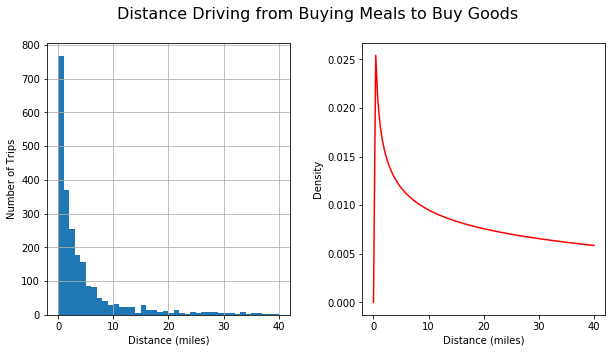

In [56]:
fig = plt.figure(figsize=(10, 5))
ax1 = fig.add_subplot(121)
ax2 = fig.add_subplot(122)
print_drive_df = worker_drive_data[(worker_drive_data.WHYTO == 11) & (worker_drive_data.WHYFROM == 13)]
b, loc, scale = stats.exponpow.fit(print_drive_df.TRPMILES)
if loc < 0.0001:
    loc = 0.0001
x = np.linspace(0, 40, 100)
ax1.set_xlabel("Distance (miles)")
ax1.set_ylabel("Number of Trips")
ax2.set_xlabel("Distance (miles)")
ax2.set_ylabel("Density")
ax2.plot(x, stats.exponpow.pdf(x, b, loc, scale), color='red')

print_drive_df.hist(column="TRPMILES", bins=40,figsize=(7,7), range=(0, 40), ax=ax1)
ax1.set_title("")
fig.suptitle("Distance Driving from Buying Meals to Buy Goods", fontsize=16)
fig.savefig("distributions/drive8.png")

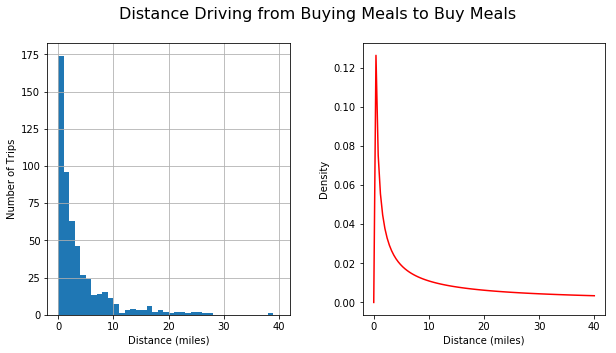

In [57]:
fig = plt.figure(figsize=(10, 5))
ax1 = fig.add_subplot(121)
ax2 = fig.add_subplot(122)
print_drive_df = worker_drive_data[(worker_drive_data.WHYTO == 13) & (worker_drive_data.WHYFROM == 13)]
b, loc, scale = stats.exponpow.fit(print_drive_df.TRPMILES)
if loc < 0.0001:
    loc = 0.0001
x = np.linspace(0, 40, 100)
ax1.set_xlabel("Distance (miles)")
ax1.set_ylabel("Number of Trips")
ax2.set_xlabel("Distance (miles)")
ax2.set_ylabel("Density")
ax2.plot(x, stats.exponpow.pdf(x, b, loc, scale), color='red')

print_drive_df.hist(column="TRPMILES", bins=40,figsize=(7,7), range=(0, 40), ax=ax1)
ax1.set_title("")
fig.suptitle("Distance Driving from Buying Meals to Buy Meals", fontsize=16)
fig.savefig("distributions/drive9.png")

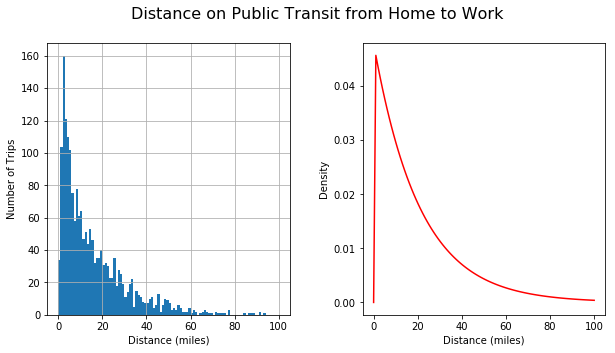

In [58]:
fig = plt.figure(figsize=(10, 5))
ax1 = fig.add_subplot(121)
ax2 = fig.add_subplot(122)
print_transit_df = worker_transit_data[(worker_transit_data.WHYTO == 3) & (worker_transit_data.WHYFROM == 1)]
loc, scale = stats.expon.fit(print_transit_df.TRPMILES)
if loc < 0.0001:
    loc = 0.0001
x = np.linspace(0, 100, 100)
ax1.set_xlabel("Distance (miles)")
ax1.set_ylabel("Number of Trips")
ax2.set_xlabel("Distance (miles)")
ax2.set_ylabel("Density")
ax2.plot(x, stats.expon.pdf(x, loc, scale), color='red')

print_transit_df.hist(column="TRPMILES", bins=100,figsize=(7,7), range=(0, 100), ax=ax1)
ax1.set_title("")
fig.suptitle("Distance on Public Transit from Home to Work", fontsize=16)
fig.savefig("distributions/transit1.png")

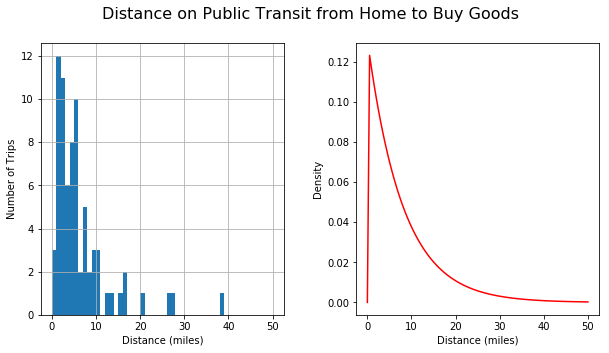

In [59]:
fig = plt.figure(figsize=(10, 5))
ax1 = fig.add_subplot(121)
ax2 = fig.add_subplot(122)
print_transit_df = worker_transit_data[(worker_transit_data.WHYTO == 11) & (worker_transit_data.WHYFROM == 1)]
loc, scale = stats.expon.fit(print_transit_df.TRPMILES)
if loc < 0.0001:
    loc = 0.0001
x = np.linspace(0, 50, 100)
ax1.set_xlabel("Distance (miles)")
ax1.set_ylabel("Number of Trips")
ax2.set_xlabel("Distance (miles)")
ax2.set_ylabel("Density")
ax2.plot(x, stats.expon.pdf(x, loc, scale), color='red')

print_transit_df.hist(column="TRPMILES", bins=50,figsize=(7,7), range=(0, 50), ax=ax1)
ax1.set_title("")
fig.suptitle("Distance on Public Transit from Home to Buy Goods", fontsize=16)
fig.savefig("distributions/transit2.png")

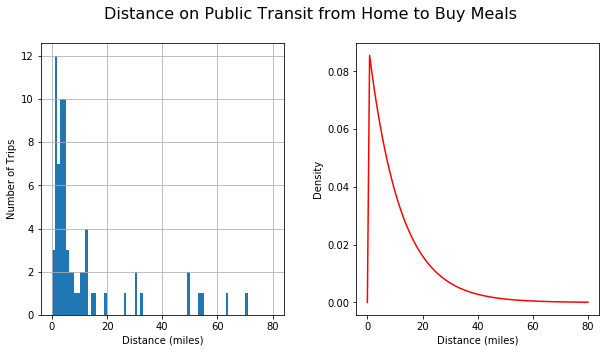

In [60]:
fig = plt.figure(figsize=(10, 5))
ax1 = fig.add_subplot(121)
ax2 = fig.add_subplot(122)
print_transit_df = worker_transit_data[(worker_transit_data.WHYTO == 13) & (worker_transit_data.WHYFROM == 1)]
loc, scale = stats.expon.fit(print_transit_df.TRPMILES)
if loc < 0.0001:
    loc = 0.0001
x = np.linspace(0, 80, 100)
ax1.set_xlabel("Distance (miles)")
ax1.set_ylabel("Number of Trips")
ax2.set_xlabel("Distance (miles)")
ax2.set_ylabel("Density")
ax2.plot(x, stats.expon.pdf(x, loc, scale), color='red')

print_transit_df.hist(column="TRPMILES", bins=80,figsize=(7,7), range=(0, 80), ax=ax1)
ax1.set_title("")
fig.suptitle("Distance on Public Transit from Home to Buy Meals", fontsize=16)
fig.savefig("distributions/transit3.png")

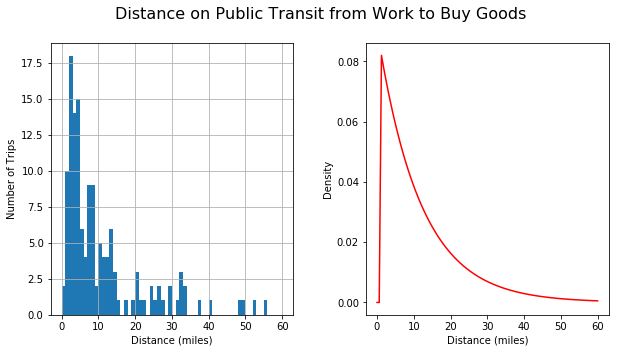

In [61]:
fig = plt.figure(figsize=(10, 5))
ax1 = fig.add_subplot(121)
ax2 = fig.add_subplot(122)
print_transit_df = worker_transit_data[(worker_transit_data.WHYTO == 11) & (worker_transit_data.WHYFROM == 3)]
loc, scale = stats.expon.fit(print_transit_df.TRPMILES)
if loc < 0.0001:
    loc = 0.0001
x = np.linspace(0, 60, 100)
ax1.set_xlabel("Distance (miles)")
ax1.set_ylabel("Number of Trips")
ax2.set_xlabel("Distance (miles)")
ax2.set_ylabel("Density")
ax2.plot(x, stats.expon.pdf(x, loc, scale), color='red')

print_transit_df.hist(column="TRPMILES", bins=60,figsize=(7,7), range=(0, 60), ax=ax1)
ax1.set_title("")
fig.suptitle("Distance on Public Transit from Work to Buy Goods", fontsize=16)
fig.savefig("distributions/transit4.png")

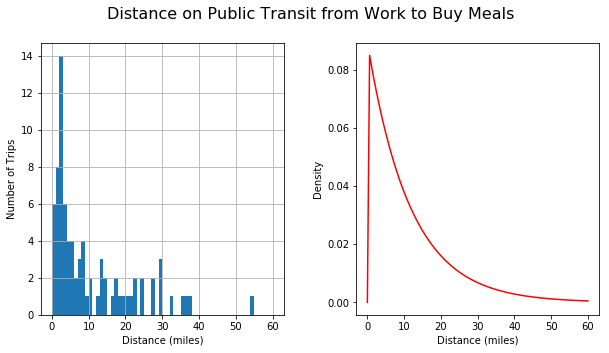

In [62]:
fig = plt.figure(figsize=(10, 5))
ax1 = fig.add_subplot(121)
ax2 = fig.add_subplot(122)
print_transit_df = worker_transit_data[(worker_transit_data.WHYTO == 13) & (worker_transit_data.WHYFROM == 3)]
loc, scale = stats.expon.fit(print_transit_df.TRPMILES)
if loc < 0.0001:
    loc = 0.0001
x = np.linspace(0, 60, 100)
ax1.set_xlabel("Distance (miles)")
ax1.set_ylabel("Number of Trips")
ax2.set_xlabel("Distance (miles)")
ax2.set_ylabel("Density")
ax2.plot(x, stats.expon.pdf(x, loc, scale), color='red')

print_transit_df.hist(column="TRPMILES", bins=60,figsize=(7,7), range=(0, 60), ax=ax1)
ax1.set_title("")
fig.suptitle("Distance on Public Transit from Work to Buy Meals", fontsize=16)
fig.savefig("distributions/transit5.png")

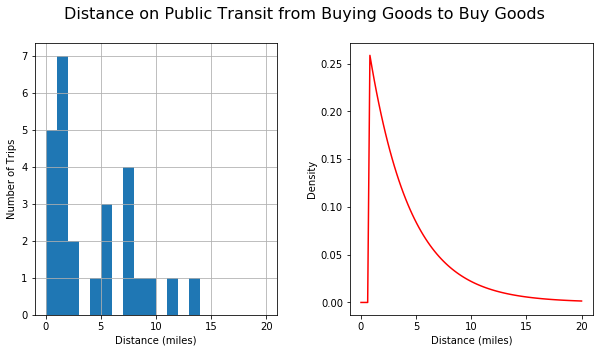

In [63]:
fig = plt.figure(figsize=(10, 5))
ax1 = fig.add_subplot(121)
ax2 = fig.add_subplot(122)
print_transit_df = worker_transit_data[(worker_transit_data.WHYTO == 11) & (worker_transit_data.WHYFROM == 11)]
loc, scale = stats.expon.fit(print_transit_df.TRPMILES)
if loc < 0.0001:
    loc = 0.0001
x = np.linspace(0, 20, 100)
ax1.set_xlabel("Distance (miles)")
ax1.set_ylabel("Number of Trips")
ax2.set_xlabel("Distance (miles)")
ax2.set_ylabel("Density")
ax2.plot(x, stats.expon.pdf(x, loc, scale), color='red')

print_transit_df.hist(column="TRPMILES", bins=20,figsize=(7,7), range=(0, 20), ax=ax1)
ax1.set_title("")
fig.suptitle("Distance on Public Transit from Buying Goods to Buy Goods", fontsize=16)
fig.savefig("distributions/transit6.png")

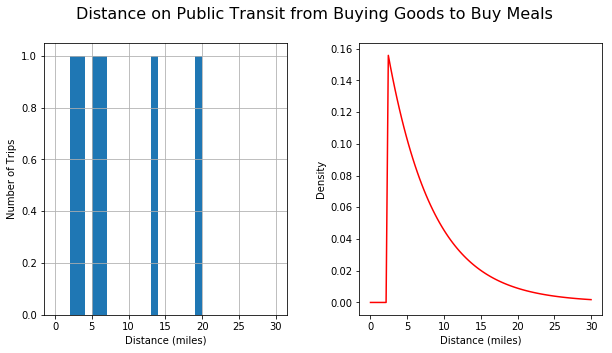

In [64]:
fig = plt.figure(figsize=(10, 5))
ax1 = fig.add_subplot(121)
ax2 = fig.add_subplot(122)
print_transit_df = worker_transit_data[(worker_transit_data.WHYTO == 13) & (worker_transit_data.WHYFROM == 11)]
loc, scale = stats.expon.fit(print_transit_df.TRPMILES)
if loc < 0.0001:
    loc = 0.0001
x = np.linspace(0, 30, 100)
ax1.set_xlabel("Distance (miles)")
ax1.set_ylabel("Number of Trips")
ax2.set_xlabel("Distance (miles)")
ax2.set_ylabel("Density")
ax2.plot(x, stats.expon.pdf(x, loc, scale), color='red')

print_transit_df.hist(column="TRPMILES", bins=30,figsize=(7,7), range=(0, 30), ax=ax1)
ax1.set_title("")
fig.suptitle("Distance on Public Transit from Buying Goods to Buy Meals", fontsize=16)
fig.savefig("distributions/transit7.png")

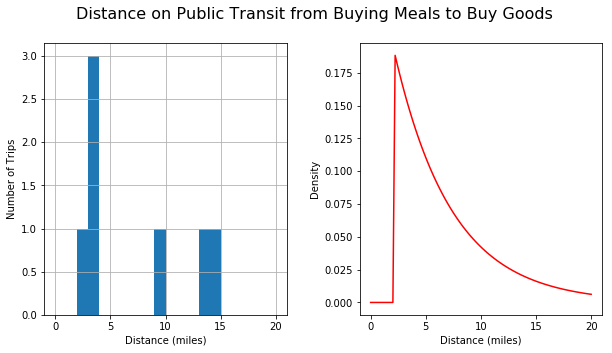

In [65]:
fig = plt.figure(figsize=(10, 5))
ax1 = fig.add_subplot(121)
ax2 = fig.add_subplot(122)
print_transit_df = worker_transit_data[(worker_transit_data.WHYTO == 11) & (worker_transit_data.WHYFROM == 13)]
loc, scale = stats.expon.fit(print_transit_df.TRPMILES)
if loc < 0.0001:
    loc = 0.0001
x = np.linspace(0, 20, 100)
ax1.set_xlabel("Distance (miles)")
ax1.set_ylabel("Number of Trips")
ax2.set_xlabel("Distance (miles)")
ax2.set_ylabel("Density")
ax2.plot(x, stats.expon.pdf(x, loc, scale), color='red')

print_transit_df.hist(column="TRPMILES", bins=20,figsize=(7,7), range=(0, 20), ax=ax1)
ax1.set_title("")
fig.suptitle("Distance on Public Transit from Buying Meals to Buy Goods", fontsize=16)
fig.savefig("distributions/transit8.png")

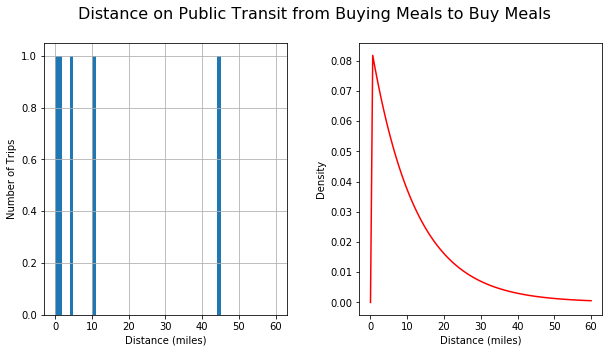

In [66]:
fig = plt.figure(figsize=(10, 5))
ax1 = fig.add_subplot(121)
ax2 = fig.add_subplot(122)
print_transit_df = worker_transit_data[(worker_transit_data.WHYTO == 13) & (worker_transit_data.WHYFROM == 13)]
loc, scale = stats.expon.fit(print_transit_df.TRPMILES)
if loc < 0.0001:
    loc = 0.0001
x = np.linspace(0, 60, 100)
ax1.set_xlabel("Distance (miles)")
ax1.set_ylabel("Number of Trips")
ax2.set_xlabel("Distance (miles)")
ax2.set_ylabel("Density")
ax2.plot(x, stats.expon.pdf(x, loc, scale), color='red')

print_transit_df.hist(column="TRPMILES", bins=60,figsize=(7,7), range=(0, 60), ax=ax1)
ax1.set_title("")
fig.suptitle("Distance on Public Transit from Buying Meals to Buy Meals", fontsize=16)
fig.savefig("distributions/transit9.png")

In [67]:
"""
end_times = {1: 200, 11: 175, 3: 900, 13: 200}
for i in WHYTO_Options:
    print_walk_df = worker_data[worker_data.WHYTO == i]
    print(print_walk_df.shape)
    print_walk_df.hist(column="DWELTIME", bins=100,figsize=(10,10), range=(0, end_times[i]))
    plt.title("Time spent at destination when destination is {}".format(option_names[i]))
"""

'\nend_times = {1: 200, 11: 175, 3: 900, 13: 200}\nfor i in WHYTO_Options:\n    print_walk_df = worker_data[worker_data.WHYTO == i]\n    print(print_walk_df.shape)\n    print_walk_df.hist(column="DWELTIME", bins=100,figsize=(10,10), range=(0, end_times[i]))\n    plt.title("Time spent at destination when destination is {}".format(option_names[i]))\n'

In [68]:
"""
# First convert all the start times from cat(hours, minutes) to total minutes, so we can't sample 975 for example
worker_data.reset_index(inplace=True, drop=True)
for i in range(len(worker_data.index)):
    worker_data.at[i, "STRTTIME"] = (worker_data.at[i, "STRTTIME"] / 100) * 60 + worker_data.at[i, "STRTTIME"] % 100
"""

'\n# First convert all the start times from cat(hours, minutes) to total minutes, so we can\'t sample 975 for example\nworker_data.reset_index(inplace=True, drop=True)\nfor i in range(len(worker_data.index)):\n    worker_data.at[i, "STRTTIME"] = (worker_data.at[i, "STRTTIME"] / 100) * 60 + worker_data.at[i, "STRTTIME"] % 100\n'

In [69]:
"""
# Generation distribution of start times
start_time_df = worker_data[worker_data.TDTRPNUM == 1]
start_time_df.hist(column="STRTTIME", bins=200,figsize=(10,10))
plt.title("Distribution of start times")
"""

'\n# Generation distribution of start times\nstart_time_df = worker_data[worker_data.TDTRPNUM == 1]\nstart_time_df.hist(column="STRTTIME", bins=200,figsize=(10,10))\nplt.title("Distribution of start times")\n'

In [70]:
"""
# Generate a best distribution using scipy. Start with normal
start_times = start_time_df.STRTTIME
#std = grouped_starts.stddev()
mu, sigma, skew = stats.skewnorm.fit(start_times)
"""

'\n# Generate a best distribution using scipy. Start with normal\nstart_times = start_time_df.STRTTIME\n#std = grouped_starts.stddev()\nmu, sigma, skew = stats.skewnorm.fit(start_times)\n'

In [71]:
"""
mu, sigma, skew = stats.skewnorm.fit(start_times)
x = np.linspace(mu - 3*sigma, mu + 3*sigma, 100)
plt.plot(x, stats.skewnorm.pdf(x, mu, sigma, skew))
start_time_df.hist(column="STRTTIME", bins=200,figsize=(10,10))
"""

'\nmu, sigma, skew = stats.skewnorm.fit(start_times)\nx = np.linspace(mu - 3*sigma, mu + 3*sigma, 100)\nplt.plot(x, stats.skewnorm.pdf(x, mu, sigma, skew))\nstart_time_df.hist(column="STRTTIME", bins=200,figsize=(10,10))\n'